# LIBRERIAS GENERALES

In [1]:
import pandas as pd
import statistics
from sklearn.metrics.pairwise import cosine_similarity
from Funciones.json_func import *
from Funciones.textblob import *
from Funciones.dates import *

.

.

.

.

# TRATAMIENTO DE STEAM GAMES

**ETL REALIZADO:**

LECTURA DE ARCHIVOS PARTICIONADOS EN FORMATO JSON GZ

RENOMBRADO DE COLUMNAS

ELIMINACION DE DATOS REDUNDANTES

ELIMINACION DE REGISTROS NULOS

ELIMINACION DE DUPLICADOS


**ITEM_ID**
 - ELIMINACION DE REGISTROS SIN ITEM_ID
 - CONVERSION A INT


**GENRES**
 - LIMPIEZA
 - ETIQUETADO ESPECIAL EN NULOS CON "DESCONOCIDO"
 - CONVERSION A CADENA DELIMITADA CON ","


**RELEASE DATE**
 - IMPUTACION FECHA DEFAULT 1900-01-01 PARA LOS CASOS NULOS O INPOSIBLES DE INFERIR
 - BUSQUEDA FUZZY CON UMBRAL DE SIMILITUD SUPERIOR AL 80%
 - SE CAPTURARON LA MAYOR CANTIDAD POSIBLE DE FECHAS, EVITANDO LA PERDIDA DE INFORMACION
 - HABIA MUCHA VARIEDAD DE FORMATOS
 - GENERACION DE COLUMNA YEAR


**PRICE**
 - LIMPIEZA
 - SE CONVIRTION A FLOAT
 - LOS QUE NO TENIAN NUMEROS O ERAN NULOS SE LOS DEJO EN NAN (porque no podemos inferior el precio)
 - LOS QUE ERAN FREE SE LE PUSO PRECIO 0

 
**DEVELOPER**
 - LIMPIEZA
 - ETIQUETADO ESPECIAL EN NULOS CON "DESCONOCIDO"

 .

 .
 

Establecemos las columnas relevantes para el MVP

In [2]:
cols_output_steam_json = ['item_id', 'genres', 'release_date', 'price', 'developer'] 

Lectura del Json.Gz de STEAM GAMES

In [3]:
#Previo a las Creacion de Particiones
#df_output_steam_json_entero = leerJsonGz("Datos/","steam_games.json.gz",0)

In [4]:
#Lectura y union de particiones
df_output_steam_json = leerJsonGzPart("Datos/Particiones/","steam_games.json.gz",0,3)

In [5]:
#Se comprobo que funciono el particionamiento de este archivo
#print("Shape lectura completa    : ", df_output_steam_json_entero.shape)
#print("Shape lectura particionada: ", df_output_steam_json.shape)


In [6]:
df_output_steam_json.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer,user_id,steam_id,items,items_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76561197970982479,76561197970982479,"[{'item_id': '10', 'item_name': 'Counter-Strik...",277.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,js41637,76561198035864385,"[{'item_id': '10', 'item_name': 'Counter-Strik...",888.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,evcentric,76561198007712555,"[{'item_id': '1200', 'item_name': 'Red Orchest...",137.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Riot-Punch,76561197963445855,"[{'item_id': '10', 'item_name': 'Counter-Strik...",328.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,doctr,76561198002099482,"[{'item_id': '300', 'item_name': 'Day of Defea...",541.0


In [7]:
df_output_steam_json.shape

(120445, 19)

In [8]:
# Renombra la columna "id" a "item_id"
df_output_steam_json.rename(columns={"id": "item_id"}, inplace=True)
df_output_steam_json.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,item_id,metascore,developer,user_id,steam_id,items,items_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76561197970982479,76561197970982479,"[{'item_id': '10', 'item_name': 'Counter-Strik...",277.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,js41637,76561198035864385,"[{'item_id': '10', 'item_name': 'Counter-Strik...",888.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,evcentric,76561198007712555,"[{'item_id': '1200', 'item_name': 'Red Orchest...",137.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Riot-Punch,76561197963445855,"[{'item_id': '10', 'item_name': 'Counter-Strik...",328.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,doctr,76561198002099482,"[{'item_id': '300', 'item_name': 'Day of Defea...",541.0


In [9]:
df_output_steam_json[df_output_steam_json['item_id'] == '10']

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,item_id,metascore,developer,user_id,steam_id,items,items_count
120416,Valve,[Action],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"[Action, FPS, Multiplayer, Shooter, Classic, T...",http://steamcommunity.com/app/10/reviews/?brow...,NaN,"[Multi-player, Valve Anti-Cheat enabled]",9.99,False,10,88,Valve,NaN,NaN,NaN,NaN


VALIDAMOS LA ESTRUCTURA ITEMS (anidada) DEL ARCHIVO STEAM GAMES

Se detecto que si viene informado ITEMs el resto de los datos es nulo.

Ademas, esa informacion ya la tenemos en USER ITEMs. Asi que sera descartada por redundancia de datos.

In [10]:
df_output_steam_json[df_output_steam_json["items"].notna()][['item_id', 'genres', 'release_date', 'price', 'developer', 'items']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 88310 entries, 0 to 88309
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   item_id       0 non-null      object
 1   genres        0 non-null      object
 2   release_date  0 non-null      object
 3   price         0 non-null      object
 4   developer     0 non-null      object
 5   items         88310 non-null  object
dtypes: object(6)
memory usage: 4.7+ MB


In [11]:
cols_output_steam_json

['item_id', 'genres', 'release_date', 'price', 'developer']

In [12]:
#Nos quedamos con las columnas necesarias para los EndPoints
df_output_steam_json = df_output_steam_json[cols_output_steam_json]

In [13]:
df_output_steam_json[cols_output_steam_json].head()

,item_id,genres,release_date,price,developer
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


ELIMINAMOS REGISTROS SIN INFORMACION, GENERADOS POR LA ESTRUCTURA ITEMs

In [14]:
df_output_steam_json.shape[0]

120445

In [15]:
#Solo elimina las filas donde todos sus campos o columnas sean Nulas.
df_output_steam_json = df_output_steam_json.dropna(how='all')

In [16]:
df_output_steam_json.shape[0]

32135

In [17]:
df_output_steam_json.head()

,item_id,genres,release_date,price,developer
88310,761140,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,4.99,Kotoshiro
88311,643980,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,Free To Play,Secret Level SRL
88312,670290,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,Free to Play,Poolians.com
88313,767400,"[Action, Adventure, Casual]",2017-12-07,0.99,彼岸领域
88314,773570,NaN,NaN,2.99,NaN


OBSERVAMOS LA PRESENCIA DE NULOS EN LAS COLUMNAS SELECCIONADAS

In [18]:
df_output_steam_json.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   item_id       32133 non-null  object
 1   genres        28852 non-null  object
 2   release_date  30068 non-null  object
 3   price         30758 non-null  object
 4   developer     28836 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


.

.

TRATAMIENTO DE NULOS CAMPO A CAMPO

.

.

ITEM-ID

In [19]:
#observamos la cantidad de registros nulos de ITEM-ID
df_output_steam_json[df_output_steam_json["item_id"].isna()].shape[0]

2

In [20]:
#observamos los registros nulos de ITEM-ID
df_output_steam_json[df_output_steam_json["item_id"].isna()]

,item_id,genres,release_date,price,developer
88384,NaN,NaN,NaN,19.99,NaN
119271,NaN,"[Action, Adventure]",2012-09-07,19.99,"Rocksteady Studios,Feral Interactive (Mac)"


Procedemos a la eliminacion de los registros sin Item_Id ya que no hay forma de imputarlo o reconstruirlo con los datos que tenemos

In [21]:
#Cantidad de Registros previo a la eliminacion
df_output_steam_json.shape[0]

32135

In [22]:
# Elimina las filas donde "item_id" sea nulo
df_output_steam_json = df_output_steam_json.dropna(subset=["item_id"])

In [23]:
#Cantidad de Registros luego de la eliminacion
df_output_steam_json.shape[0]

32133

In [24]:
#Convertimos la columna a Entero
df_output_steam_json['item_id'] = df_output_steam_json['item_id'].astype(int)

GENRES

VALIDO CUANTOS GENROS DIFERENTES TENGO PREVIO A CUALQUIER MODIFICACION

In [25]:
# Convierto en string
# Si no es lista se pasa directo a string
#Si es lista, se conveierte a cadena, separando los elementos (generos) por coma.
genres_str = df_output_steam_json["genres"].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# Dividir la columna 'genres' en géneros individuales y crear un conjunto de géneros únicos
unique_genres_set = set(genres_str.str.split(',').explode().str.strip())

# Convertir el conjunto de géneros únicos en una lista
unique_genres_list = list(unique_genres_set)

# Mostrar la lista de géneros únicos
print(unique_genres_list)
print(len(unique_genres_list))


['Utilities', 'Education', 'Design &amp; Illustration', 'Video Production', 'Audio Production', 'Photo Editing', 'Indie', 'Software Training', 'Accounting', 'Massively Multiplayer', 'Free to Play', 'Early Access', 'Casual', 'Animation &amp; Modeling', 'Web Publishing', 'Simulation', 'nan', 'Strategy', 'RPG', 'Sports', 'Action', 'Adventure', 'Racing']
23


In [26]:
#observamos la cantidad de registros nulos en el campo GENRES
df_output_steam_json[df_output_steam_json["genres"].isna()].shape[0]

3282

In [27]:
df_output_steam_json[df_output_steam_json["genres"].isna()].head()

,item_id,genres,release_date,price,developer
88314,773570,NaN,NaN,2.99,NaN
88321,724910,NaN,NaN,Free,NaN
88329,772590,NaN,NaN,4.99,NaN
88330,640250,NaN,NaN,2.99,NaN
88332,711440,NaN,NaN,0.99,NaN


Debido a que es muy dificil obtener un resultado CONFIABLE al tratar de inferir los generos con el resto de la informacion disponible, se ha optado por hacer un ETIQUETADO especial a esos registros con generos nulos.

Se procedera a imputar ["Desconocido] a todos esos casos con el objetivo de no perder informacion relevante como ser: precios, fechas, etc.

In [28]:
#eliminamos los elementos o generos 'Free To Play' y 'Early Access' ya que condiseramos no ser un genero.
df_output_steam_json['genres'] = df_output_steam_json['genres'].apply(lambda x: [genre for genre in x if isinstance(x, list) and genre != 'Free to Play'] if isinstance(x, list) else x)
df_output_steam_json['genres'] = df_output_steam_json['genres'].apply(lambda x: [genre for genre in x if isinstance(x, list) and genre != 'Early Access'] if isinstance(x, list) else x)

#Si solamente tenia ese genero, me va a quedar una lista vacia, en esos casos imputo Desconocido
df_output_steam_json['genres'] = df_output_steam_json['genres'].apply(lambda x: ['Desconocido'] if (isinstance(x, list) and (len(x) == 0 or (len(x) == 1 and x[0] == ''))) else x)

In [29]:
# Convierto en string
# Si no es lista se pasa directo a string
#Si es lista, se conveierte a cadena, separando los elementos (generos) por coma.
genres_str = df_output_steam_json["genres"].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# Dividir la columna 'genres' en géneros individuales y crear un conjunto de géneros únicos
unique_genres_set = set(genres_str.str.split(',').explode().str.strip())

# Convertir el conjunto de géneros únicos en una lista
unique_genres_list = list(unique_genres_set)

# Mostrar la lista de géneros únicos
print(unique_genres_list)
print(len(unique_genres_list))

['Utilities', 'Education', 'Design &amp; Illustration', 'Video Production', 'Audio Production', 'Photo Editing', 'Indie', 'Software Training', 'Accounting', 'Massively Multiplayer', 'Desconocido', 'Casual', 'Animation &amp; Modeling', 'Web Publishing', 'Simulation', 'nan', 'Strategy', 'RPG', 'Sports', 'Action', 'Adventure', 'Racing']
22


transformo la columna de genres en string

In [30]:
# Verifica el contenido de GENRES
# Si no es lista se pasa directo a string
#Si es lista, se conveierte a cadena, separando los elementos (generos) por coma.
df_output_steam_json["genres"] = df_output_steam_json["genres"].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)).str.strip()

In [31]:
# Verifica y asigna "Desconocido" a registros nulos y vacios en la columna "genres"
df_output_steam_json['genres'] = df_output_steam_json['genres'].apply(lambda x: "Desconocido" if x == 'nan' else x)
df_output_steam_json['genres'] = df_output_steam_json['genres'].apply(lambda x: "Desconocido" if x == '' else x)

In [32]:
#observamos los registros nulos tras la imputacion
df_output_steam_json[df_output_steam_json["genres"].isna()].shape[0]

0

In [33]:
df_output_steam_json[df_output_steam_json['genres'] == ''].shape[0]

0

In [34]:
# Sustituir la subcadena 'Design &amp; ' por ''
df_output_steam_json['genres'] = df_output_steam_json['genres'].str.replace('Design &amp; ', '')
df_output_steam_json['genres'] = df_output_steam_json['genres'].str.replace('Animation &amp; ', '')
df_output_steam_json['genres'] = df_output_steam_json['genres'].str.rstrip(', ')

In [35]:
df_output_steam_json[df_output_steam_json['genres'] == ''].shape[0]

0

In [36]:
df_output_steam_json.head()

,item_id,genres,release_date,price,developer
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro
88311,643980,"Indie, RPG, Strategy",2018-01-04,Free To Play,Secret Level SRL
88312,670290,"Casual, Indie, Simulation, Sports",2017-07-24,Free to Play,Poolians.com
88313,767400,"Action, Adventure, Casual",2017-12-07,0.99,彼岸领域
88314,773570,Desconocido,NaN,2.99,NaN


RELEASE_DATE

In [37]:
#observamos los registros nulos
df_output_steam_json[df_output_steam_json["release_date"].isna()].shape[0]

2066

Debido a que es muy dificil obtener un resultado CONFIABLE al tratar de inferir las FECHAS de LANZAMIENTO con el resto de la informacion disponible, se ha optado por imputar un valor especial a esos registros con fechas nulas.

Se procedera a imputar 1900-01-01 a todos esos casos con el objetivo de no perder informacion relevante.

In [38]:
#Previo a dicha imputacion comprobamos que esa fecha NO se este utilizando
df_output_steam_json[df_output_steam_json["release_date"].str.strip() == "1900-01-01"].shape[0]

0

In [39]:
#Visualizo un registro para ver como imputa la fecha default
df_output_steam_json[df_output_steam_json["release_date"].isna()].head(1)

,item_id,genres,release_date,price,developer
88314,773570,Desconocido,NaN,2.99,NaN


In [40]:
# Asigna '1900-01-01' a los registros nulos en la columna "release_date"
df_output_steam_json["release_date"].fillna(pd.to_datetime(DEFAULT_DATE).date().strftime("%Y-%m-%d"), inplace=True)

In [41]:
#observamos los registros nulos tras la imputacion
df_output_steam_json[df_output_steam_json["release_date"].isna()].shape[0]

0

In [42]:
#Visualizo el registro anterior post imputacion de DEFAULT DATE
df_output_steam_json[df_output_steam_json["item_id"] == 773570]

,item_id,genres,release_date,price,developer
88314,773570,Desconocido,1900-01-01,2.99,NaN


Necesitamos verificar la diversidad de posibilidades que nos podemos encontrar ya que manualmente hemos observado muchos tipos de fechas. 

Vamos a Realizar una separacion de los datos que no estan bajo el formato YYYY-MM-DD

In [43]:
df_output_steam_json.head()

,item_id,genres,release_date,price,developer
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro
88311,643980,"Indie, RPG, Strategy",2018-01-04,Free To Play,Secret Level SRL
88312,670290,"Casual, Indie, Simulation, Sports",2017-07-24,Free to Play,Poolians.com
88313,767400,"Action, Adventure, Casual",2017-12-07,0.99,彼岸领域
88314,773570,Desconocido,1900-01-01,2.99,NaN


In [44]:
#Casteamos a String
df_output_steam_json['release_date'] = df_output_steam_json['release_date'].astype(str)

# Aplica la función de conversión a la columna 'release_date'
df_output_steam_json['converted_release_date'] = df_output_steam_json['release_date'].apply(convertReleaseFuzzy)

VALIDAMOS QUE TODAS LAS FECHAS SE HAYAN TRATADO CORRECTAMENTE

In [45]:
# Filtra los registros que no se pudieron convertir
failed_conversion_df = df_output_steam_json[df_output_steam_json['converted_release_date'].isna()]

# Muestra el nuevo DataFrame con el conteo de valores
print("Cantidad de Fechas que no pudieron ser tratadas: ", failed_conversion_df.shape[0])

Cantidad de Fechas que no pudieron ser tratadas:  0


In [46]:
df_output_steam_json[df_output_steam_json['release_date'] == pd.to_datetime(DEFAULT_DATE).date().strftime("%Y-%m-%d")]

,item_id,genres,release_date,price,developer,converted_release_date
88314,773570,Desconocido,1900-01-01,2.99,NaN,1900-01-01
88321,724910,Desconocido,1900-01-01,Free,NaN,1900-01-01
88329,772590,Desconocido,1900-01-01,4.99,NaN,1900-01-01
88330,640250,Desconocido,1900-01-01,2.99,NaN,1900-01-01
88332,711440,Desconocido,1900-01-01,0.99,NaN,1900-01-01
...,...,...,...,...,...,...
120387,705860,Desconocido,1900-01-01,Free,NaN,1900-01-01
120394,729640,"Action, Casual, Indie",1900-01-01,NaN,The BOMBFEST Team,1900-01-01
120395,755540,Desconocido,1900-01-01,NaN,NaN,1900-01-01
120398,708070,"Action, Adventure, Indie",1900-01-01,NaN,rechargecomplete,1900-01-01


In [47]:
df_output_steam_json[(df_output_steam_json['converted_release_date'] == DEFAULT_DATE) & (df_output_steam_json['release_date'] != DEFAULT_DATE)]

,item_id,genres,release_date,price,developer,converted_release_date
88354,714020,"Adventure, RPG",Beta测试已开启,NaN,"zha7,Phaedruns,Yingke Wu",1900-01-01
95499,504690,"Adventure, Casual, Indie",TBA,NaN,"Alterego Games,Digital Forest",1900-01-01
96648,533800,"Indie, Simulation",When it's done,NaN,Steven Colling,1900-01-01
97645,618560,"Action, Adventure, Indie",TBA,NaN,Wisp Entertainment,1900-01-01
98793,658340,Indie,14 July,NaN,Grotta Game Studio,1900-01-01
99652,601380,"Action, Adventure, Indie",To be Announced,NaN,Phoenix Interactive Studio,1900-01-01
100004,606000,"Action, Adventure, Indie, RPG",TBA,NaN,Monster Couch,1900-01-01
100146,555980,"Indie, RPG",TBD,NaN,LEVER Software,1900-01-01
100850,692260,"Adventure, Indie, RPG, Simulation, Strategy",TBD,NaN,Siberian Digital,1900-01-01
101259,752570,"Adventure, Casual",2018年初頭発売予定,NaN,"Future Tech Lab Co.,Ltd.",1900-01-01


In [48]:
df_output_steam_json.head()

,item_id,genres,release_date,price,developer,converted_release_date
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro,2018-01-04
88311,643980,"Indie, RPG, Strategy",2018-01-04,Free To Play,Secret Level SRL,2018-01-04
88312,670290,"Casual, Indie, Simulation, Sports",2017-07-24,Free to Play,Poolians.com,2017-07-24
88313,767400,"Action, Adventure, Casual",2017-12-07,0.99,彼岸领域,2017-12-07
88314,773570,Desconocido,1900-01-01,2.99,NaN,1900-01-01


In [49]:
#Asignamos una columna a la otra
df_output_steam_json['release_date'] = df_output_steam_json['converted_release_date']
#eliminamos Columna intermedia 
df_output_steam_json.drop(columns=['converted_release_date'], inplace=True)

GENERAMOS COLUMNA YEAR que nos sera util para los endpoints

In [50]:
# Extraer el año de la columna 'release_date'
df_output_steam_json['year'] = df_output_steam_json['release_date'].str[:4]

# Convertir la columna 'year' a tipo numérico
df_output_steam_json['year'] = pd.to_numeric(df_output_steam_json['year'], errors='coerce')

In [51]:
#convertimos a String
df_output_steam_json['release_date'] = df_output_steam_json['release_date'].astype(str)

In [52]:
df_output_steam_json.head()

,item_id,genres,release_date,price,developer,year
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro,2018
88311,643980,"Indie, RPG, Strategy",2018-01-04,Free To Play,Secret Level SRL,2018
88312,670290,"Casual, Indie, Simulation, Sports",2017-07-24,Free to Play,Poolians.com,2017
88313,767400,"Action, Adventure, Casual",2017-12-07,0.99,彼岸领域,2017
88314,773570,Desconocido,1900-01-01,2.99,NaN,1900


PRICE

In [53]:
# Convierte la columna 'price' a numérica, y los valores no válidos se convierten en NaN
df_output_steam_json['price_convertidos'] = pd.to_numeric(df_output_steam_json['price'], errors='coerce')

In [54]:
df_output_steam_json[df_output_steam_json['item_id'] == 761140]

,item_id,genres,release_date,price,developer,year,price_convertidos
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro,2018,4.99


In [55]:
#vemos que price tenian aquellos que no hemos podido convertir para ver como tratarlos
df_output_steam_json[df_output_steam_json['price_convertidos'].isna()].head()

,item_id,genres,release_date,price,developer,year,price_convertidos
88311,643980,"Indie, RPG, Strategy",2018-01-04,Free To Play,Secret Level SRL,2018,NaN
88312,670290,"Casual, Indie, Simulation, Sports",2017-07-24,Free to Play,Poolians.com,2017,NaN
88319,768800,"Casual, Indie, Racing, Simulation",2018-01-04,NaN,RewindApp,2018,NaN
88320,768570,"Action, Indie, Simulation",1900-07-01,NaN,Qucheza,1900,NaN
88321,724910,Desconocido,1900-01-01,Free,NaN,1900,NaN


In [56]:
#nos quedamos con los valores unicos de esos Prices extraños
df_output_steam_json[df_output_steam_json['price_convertidos'].isna()]['price'].unique()

array(['Free To Play', 'Free to Play', nan, 'Free', 'Free Demo',
       'Play for Free!', 'Install Now', 'Play WARMACHINE: Tactics Demo',
       'Free Mod', 'Install Theme', 'Third-party', 'Play Now',
       'Free HITMAN™ Holiday Pack', 'Play the Demo',
       'Starting at $499.00', 'Starting at $449.00', 'Free to Try',
       'Free Movie', 'Free to Use'], dtype=object)

Realizamos las transformaciones de esos casos extraños

In [57]:
#Casos con Starting at $
df_output_steam_json['price'] = df_output_steam_json['price'].apply(lambda x: x.replace('Starting at $', '') if isinstance(x, str) and 'Starting at $' in x else x)

In [58]:
#Modificamos los FREE
# Utiliza str.contains() para identificar registros que contienen "free" (sin importar mayúsculas o minúsculas)
# Modifica los registros que cumplen con la condición a 0.0
df_output_steam_json.loc[df_output_steam_json['price'].str.contains('free', case=False, na=False), 'price'] = 0.0

Volvemos a aplicar la conversion...

In [59]:
# Convierte la columna 'price' a numérica, y los valores no válidos se convierten en NaN
df_output_steam_json['price_convertidos'] = pd.to_numeric(df_output_steam_json['price'], errors='coerce')

In [60]:
#nos quedamos con los valores unicos de esos Prices extraños
df_output_steam_json[df_output_steam_json['price_convertidos'].isna()]['price'].unique()

array([nan, 'Install Now', 'Play WARMACHINE: Tactics Demo',
       'Install Theme', 'Third-party', 'Play Now', 'Play the Demo'],
      dtype=object)

ASUMIMOS COMO AUSENCIA DE INFORMACION PARA ESOS CASOS, CON LO CUAL QUEDARAN CON NaN luego de la transformacion.

In [61]:
df_output_steam_json['price'] = df_output_steam_json['price_convertidos']
df_output_steam_json.drop('price_convertidos', axis=1, inplace=True)

In [62]:
df_output_steam_json.head()

,item_id,genres,release_date,price,developer,year
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro,2018
88311,643980,"Indie, RPG, Strategy",2018-01-04,0.00,Secret Level SRL,2018
88312,670290,"Casual, Indie, Simulation, Sports",2017-07-24,0.00,Poolians.com,2017
88313,767400,"Action, Adventure, Casual",2017-12-07,0.99,彼岸领域,2017
88314,773570,Desconocido,1900-01-01,2.99,NaN,1900


In [63]:
df_output_steam_json[df_output_steam_json['item_id'] == 761140]

,item_id,genres,release_date,price,developer,year
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro,2018


DEVELOPER

In [64]:
#Visualizamos algunos registros con DEVELOPER nulo
df_output_steam_json[df_output_steam_json['developer'].isna()]

,item_id,genres,release_date,price,developer,year
88314,773570,Desconocido,1900-01-01,2.99,NaN,1900
88321,724910,Desconocido,1900-01-01,0.00,NaN,1900
88329,772590,Desconocido,1900-01-01,4.99,NaN,1900
88330,640250,Desconocido,1900-01-01,2.99,NaN,1900
88332,711440,Desconocido,1900-01-01,0.99,NaN,1900
...,...,...,...,...,...,...
120428,775640,Desconocido,2018-01-03,3.99,NaN,2018
120429,777930,Desconocido,2018-01-03,3.99,NaN,2018
120430,775370,Desconocido,2016-11-19,4.99,NaN,2016
120431,777950,Desconocido,2018-01-03,0.00,NaN,2018


In [65]:
#Cantidad total de nulos en columna DEVELOPER previo a la imputacion
df_output_steam_json[df_output_steam_json['developer'].isna()].shape[0]

3298

In [66]:
# Verifica y asigna "Desconocido" a registros nulos en la columna "developer"
df_output_steam_json['developer'] = df_output_steam_json['developer'].apply(lambda x: "Desconocido" if pd.isna(x) else x)

In [67]:
#Cantidad total de nulos en columna DEVELOPER luego de la imputacion
df_output_steam_json[df_output_steam_json['developer'].isna()].shape[0]

0

In [68]:
#Visualizamos algunos registros
df_output_steam_json.head()

,item_id,genres,release_date,price,developer,year
88310,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro,2018
88311,643980,"Indie, RPG, Strategy",2018-01-04,0.00,Secret Level SRL,2018
88312,670290,"Casual, Indie, Simulation, Sports",2017-07-24,0.00,Poolians.com,2017
88313,767400,"Action, Adventure, Casual",2017-12-07,0.99,彼岸领域,2017
88314,773570,Desconocido,1900-01-01,2.99,Desconocido,1900


In [69]:
#Cantidad de Developers diferentes
df_output_steam_json['developer'].unique().shape[0]

10993

In [70]:
df_output_steam_json['developer'] = df_output_steam_json['developer'].str.strip()

In [71]:
#Cantidad de Developers diferentes
df_output_steam_json['developer'].unique().shape[0]

10993

UNA VEZ FINALIZADAS TODAS LAS TRANSFORMACIONES VOLVEMOS A ELIMINAR DUPLICADOS POR LAS DUDAS

In [72]:
#Vemos cantidad de Registros antes de la eliminacion
df_output_steam_json.shape[0]

32133

In [73]:
# Elimina registros duplicados en el DataFrame
df_output_steam_json.drop_duplicates(inplace=True)

In [74]:
#Vemos cantidad de Registros despues de la eliminacion
df_output_steam_json.shape[0]

32132

In [75]:
#Reseteamos indices
df_output_steam_json.reset_index(drop=True, inplace=True)

In [76]:
#Convertimos a string
df_output_steam_json['developer'] = df_output_steam_json['developer'].astype(str)

.

.

.

# USER REVIEWS

**ETL REALIZADO:**

LECTURA DE ARCHIVOS PARTICIONADOS EN FORMATO JSON GZ

DESANIDADO DE COLUMNA REVIEWS

ELIMINACION DE DATOS REDUNDANTES

ELIMINACION DE REGISTROS NULOS O REGISTROS QUE NO APORTABAN INFORMACION RELEVANTE (Cuando review y recommend estan sin informacion)

ELIMINACION DE DUPLICADOS

**POSTED**
 - LIMPIEZA DE CAMPO YA QUE CONTENIA TEXTO ADEMAS DE FECHAS
 - IMPUTACION FECHA DEFAULT 1900-01-01 PARA LOS CASOS NULOS O INPOSIBLES DE INFERIR
 - BUSQUEDA FUZZY CON UMBRAL DE SIMILITUD SUPERIOR AL 80%
 - SE CAPTURARON LA MAYOR CANTIDAD POSIBLE DE FECHAS, EVITANDO LA PERDIDA DE INFORMACION
 - HABIA MUCHA VARIEDAD DE FORMATOS
 - PARA LOS POSTEOS SIN AÑO, SE IMPUTO EL AÑO DEL RELEASE_DATE SI ES QUE EXISTIA INFORMACION PARA ESE ITEM_ID.
 - GENERACION DE COLUMNA YEAR

 
**RECOMMEND**
 - CONVERSION A ENTERO, PASANTO LOS TRUE COMO 1 Y LOS FALSE COMO 0.

**ITEM_ID**
 - CONVERSION A INT


**ANALISIS DE SENTIMIENTO**
 - SE UTILIZO TEXTBLOB PORQUE ERA UNA DE LAS OPCIONES MAS LIVIANAS Y APROPIADAS AL NO CONTAR CON DATOS ETIQUETADOS PARA ENTRENAR ALGUN MODELO MAS EFICIENTE.
 - SE UTILIZO UMBRALES +0.2 Y -0.2 DE POLARIDAD PARA CATEGORIZAR LAS REVIEW EN 0 (NEGATIVAS), 1(NEUTRAS) Y 2(POSITIVAS).
 - SI NO TENIA REVIEW SE IMPUTO 1(NEUTRAS).
 - CONVERSION DE LA COLUMNA sentiment_analysis A INT.

 .

 .

Establecemos las columnas relevantes para el MVP

In [77]:
cols_user_reviews = ["user_id", "posted", "item_id", "recommend", "review"]

LECTURA

In [78]:
#Lectura previa al particionamiento
#df_user_reviews_entero = leerJsonGz("Datos/", "user_reviews.json.gz",1)

In [79]:
#Lectura y union de particiones
df_user_reviews = leerJsonGzPart("Datos/Particiones/","user_reviews.json.gz",0,3)

In [80]:
#Se comprobo que el particionamiento ha funcionado
#print("Shape Lectura Completa    : ",df_user_reviews_entero.shape)
#print("Shape Lectura Particionada: ",df_user_reviews.shape)

In [81]:
#visualizamos DF
df_user_reviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


DESANIDAMOS

Invoca a la funcion que desanida los json. En este caso, abrira en tantas columnas como claves tengan los diccionarios que estan dentro de la estructura REVIEWS

In [82]:
print("Cantidad de Registros sin desanidar: ", df_user_reviews.shape[0])
print("Cantidad de Columnas  sin desanidar: ", df_user_reviews.shape[1])

Cantidad de Registros sin desanidar:  25799
Cantidad de Columnas  sin desanidar:  3


In [83]:
df_user_reviews = desanidarJson(df_user_reviews, 'reviews')
df_user_reviews.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


In [84]:
print("Cantidad de Registros luego de desanidar: ", df_user_reviews.shape[0])
print("Cantidad de Columnas  luego de desanidar: ", df_user_reviews.shape[1])

Cantidad de Registros luego de desanidar:  59333
Cantidad de Columnas  luego de desanidar:  9


In [85]:
#Me quedo con las columnas Relevantes para el MVP
df_user_reviews = df_user_reviews[cols_user_reviews]
df_user_reviews.head()

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability. In my opi...
1,76561197970982479,"Posted July 15, 2011.",22200,True,It's unique and worth a playthrough.
2,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
4,js41637,"Posted September 8, 2013.",227300,True,For a simple (it's actually not all that simpl...


ELIMINO REGISTROS QUE NO ME SIRVEN

- Cuando review y recommend estan sin informacion, ya que no me aportan ninguna informacion esos registros.

In [86]:
df_user_reviews = df_user_reviews.dropna(subset=['recommend', 'review'], how='all')
df_user_reviews.reset_index(drop=True, inplace=True)
df_user_reviews.shape

(59305, 5)

In [87]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59305 non-null  object
 1   posted     59305 non-null  object
 2   item_id    59305 non-null  object
 3   recommend  59305 non-null  object
 4   review     59305 non-null  object
dtypes: object(5)
memory usage: 2.3+ MB


==> Podemos ver que no hay mas valores nulos

.



TRANSFORMACIONES

.



POSTED

La fecha Viene sin año en algunos casos y ademas esta en un formato poco util. vamos a proceder a llevarla a YYYY-MM-DD al igual que lo hicimos con RELEASE_DATE.

In [88]:
#Quito Espacios
df_user_reviews['posted'] = df_user_reviews['posted'].str.strip()
#Quitamos palabra 'Posted' y el '.' final.
df_user_reviews['posted'] = df_user_reviews['posted'].str.replace('Posted ', '').str.replace('.', '')
#No hay nulos, pero si los hubiera completariamos con una fecha default
df_user_reviews['posted'].fillna(DEFAULT_DATE_LONG, inplace=True)
# Realiza el cambio de formato de la FECHA hacia YYYY-MM-DD
df_user_reviews['posted_new'] = df_user_reviews['posted'].apply(convertPosted)
df_user_reviews.head()

,user_id,posted,item_id,recommend,review,posted_new
0,76561197970982479,"November 5, 2011",1250,True,Simple yet with great replayability. In my opi...,2011-11-05
1,76561197970982479,"July 15, 2011",22200,True,It's unique and worth a playthrough.,2011-07-15
2,76561197970982479,"April 21, 2011",43110,True,Great atmosphere. The gunplay can be a bit chu...,2011-04-21
3,js41637,"June 24, 2014",251610,True,I know what you think when you see this title ...,2014-06-24
4,js41637,"September 8, 2013",227300,True,For a simple (it's actually not all that simpl...,2013-09-08


Confirmamos nuevamente que no hay posteos sin fecha

In [89]:
print("Cantidad de Fechas Default en USER REVIEWs: ", df_user_reviews[df_user_reviews["posted"] == "1900-01-01"].shape[0])

Cantidad de Fechas Default en USER REVIEWs:  0


In [90]:
df_user_reviews["posted"].isna().value_counts()

posted
False    59305
Name: count, dtype: int64

Veo cuantas fechas hay con año 1900

In [91]:
df_user_reviews[df_user_reviews['posted_new'].str.contains('1900')]

,user_id,posted,item_id,recommend,review,posted_new
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-02-03
27,76561198079601835,May 20,730,True,ZIKA DO BAILE,1900-05-20
28,MeaTCompany,July 24,730,True,BEST GAME IN THE BLOODY WORLD,1900-07-24
31,76561198156664158,June 16,252950,True,love it,1900-06-16
32,76561198077246154,June 11,440,True,mt bom,1900-06-11
...,...,...,...,...,...,...
59300,76561198312638244,July 10,70,True,a must have classic from steam definitely wort...,1900-07-10
59301,76561198312638244,July 8,362890,True,this game is a perfect remake of the original ...,1900-07-08
59302,LydiaMorley,July 3,273110,True,had so much fun plaing this and collecting res...,1900-07-03
59303,LydiaMorley,July 20,730,True,:D,1900-07-20


Se pudo ver que las fechas, luego de aplicar el drop de registros sin recommend y sin revew, vienen siempre informadas. Pero hay un defecto. Hay fechas sin año, es decir, viene solo mes y dia.

==> **Imputamos como año de Posteo el correspondiente a La fecha de Lanzamiento del Contenido:**

In [92]:
# Creamos series booleanas para buscar las fechas con año 1900 pero que no tengan dia y mes 01.
#Si tiene año 1900 y no es 01 el dia y mes, quiere decir que es una feha que vino informada SIN año. En ese caso imputamos año de lantamiento si es que lo tenemos. Sino DEFAULT_DATE.
es_1900  = df_user_reviews['posted_new'].str[:4] == "1900"
no_es_01 = df_user_reviews['posted_new'].str[4:9] != "01-01"
# Combina las condiciones
es_1900_y_no_es_01 = es_1900 & no_es_01
# Filtra el DataFrame para obtener las filas que cumplen con las condiciones
df_user_reviews[es_1900_y_no_es_01].head(10)

,user_id,posted,item_id,recommend,review,posted_new
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-02-03
27,76561198079601835,May 20,730,True,ZIKA DO BAILE,1900-05-20
28,MeaTCompany,July 24,730,True,BEST GAME IN THE BLOODY WORLD,1900-07-24
31,76561198156664158,June 16,252950,True,love it,1900-06-16
32,76561198077246154,June 11,440,True,mt bom,1900-06-11
54,Fr0stedLine,February 27,220,True,Hermoso juego que nunca olvidare <3,1900-02-27
56,starkillershadow553,August 23,242130,True,"If you're looking for a no frills, Arcade/Simu...",1900-08-23
60,76561198048353577,May 16,4000,True,Top Quality. Star Wars RP is the bomb.,1900-05-16
65,76561198070565427,March 31,218620,True,ผมว่าคุ้มที่สุดเเห่งเกมที่ผมเล่นมาผมน่าจะเจอเก...,1900-03-31
74,Leaf_Light_Moscow,July 9,323370,True,Just amazing,1900-07-09


In [93]:
#comprobacion de un caso puntual con DEFAULT
df_user_reviews[(df_user_reviews['item_id'] == '248820') & (df_user_reviews['user_id'] == 'evcentric')]

,user_id,posted,item_id,recommend,review,posted_new
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-02-03


In [94]:
#Vemos cuantos casos de estos tenemos en nuestro data frame
df_user_reviews[es_1900_y_no_es_01].shape[0]

10119

In [95]:
#Reseteamos indices
df_user_reviews.reset_index(drop=True, inplace=True)

In [96]:
df_user_reviews_filtrado = df_user_reviews[es_1900_y_no_es_01]

# Para cada registro en los registros filtrados
for indice, fila in df_user_reviews_filtrado.iterrows():
    item_id = fila['item_id']  # Obtiene el valor de 'item_id' de df_user_reviews
    
    # Busca las coincidencias para item_id en df_output_steam_json
    coincidencias = df_output_steam_json[df_output_steam_json['item_id'] == item_id]
    
    # Verifica si se encontraron coincidencias antes de intentar acceder al valor
    if not coincidencias.empty:
        # Obtén el primer valor de 'release_date' en las coincidencias
        anio_release = coincidencias['release_date'].str[:4].values[0]
        # Actualiza solo los primeros 4 caracteres de 'posted_new' en df_user_reviews
        df_user_reviews.at[indice, 'posted_new'] = anio_release + df_user_reviews.at[indice, 'posted_new'][4:]

In [97]:
df_user_reviews[es_1900_y_no_es_01].head(10)

,user_id,posted,item_id,recommend,review,posted_new
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-02-03
27,76561198079601835,May 20,730,True,ZIKA DO BAILE,1900-05-20
28,MeaTCompany,July 24,730,True,BEST GAME IN THE BLOODY WORLD,1900-07-24
31,76561198156664158,June 16,252950,True,love it,1900-06-16
32,76561198077246154,June 11,440,True,mt bom,1900-06-11
54,Fr0stedLine,February 27,220,True,Hermoso juego que nunca olvidare <3,1900-02-27
56,starkillershadow553,August 23,242130,True,"If you're looking for a no frills, Arcade/Simu...",1900-08-23
60,76561198048353577,May 16,4000,True,Top Quality. Star Wars RP is the bomb.,1900-05-16
65,76561198070565427,March 31,218620,True,ผมว่าคุ้มที่สุดเเห่งเกมที่ผมเล่นมาผมน่าจะเจอเก...,1900-03-31
74,Leaf_Light_Moscow,July 9,323370,True,Just amazing,1900-07-09


In [98]:
#comprobacion de un caso puntual con DEFAULT
df_output_steam_json[df_output_steam_json['item_id'] == 218620]

,item_id,genres,release_date,price,developer,year
30067,218620,Desconocido,1900-01-01,4.99,Desconocido,1900


Ahora solo aplicamos DEFAULT_DATE para aquellas fechas de posteo que aun tengan año 1900

In [99]:
# Filtra el DataFrame para obtener las filas que cumplen con las condiciones
es_1900  = df_user_reviews['posted_new'].str[:4] == "1900"
df_user_reviews[es_1900].head(10)

,user_id,posted,item_id,recommend,review,posted_new
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-02-03
27,76561198079601835,May 20,730,True,ZIKA DO BAILE,1900-05-20
28,MeaTCompany,July 24,730,True,BEST GAME IN THE BLOODY WORLD,1900-07-24
31,76561198156664158,June 16,252950,True,love it,1900-06-16
32,76561198077246154,June 11,440,True,mt bom,1900-06-11
54,Fr0stedLine,February 27,220,True,Hermoso juego que nunca olvidare <3,1900-02-27
56,starkillershadow553,August 23,242130,True,"If you're looking for a no frills, Arcade/Simu...",1900-08-23
60,76561198048353577,May 16,4000,True,Top Quality. Star Wars RP is the bomb.,1900-05-16
65,76561198070565427,March 31,218620,True,ผมว่าคุ้มที่สุดเเห่งเกมที่ผมเล่นมาผมน่าจะเจอเก...,1900-03-31
74,Leaf_Light_Moscow,July 9,323370,True,Just amazing,1900-07-09


In [100]:
#validacion de caso puntual item_id = 271290
#Como no se encontro en el df, no actualizo el año
df_output_steam_json[df_output_steam_json['item_id'] == 271290]

,item_id,genres,release_date,price,developer,year


In [101]:
#imputamos DEFAULT_DATE en estos casos

# Filtro para identificar los registros que cumplen con es_1900
registros_es_1900 = df_user_reviews[es_1900]

# Modificar la columna 'posted_new' en los registros filtrados
registros_es_1900.loc[:, 'posted_new'] = DEFAULT_DATE

# Actualizar df_user_reviews con los cambios
df_user_reviews.update(registros_es_1900)

In [102]:
df_user_reviews[es_1900].head(10)

,user_id,posted,item_id,recommend,review,posted_new
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-01-01
27,76561198079601835,May 20,730,True,ZIKA DO BAILE,1900-01-01
28,MeaTCompany,July 24,730,True,BEST GAME IN THE BLOODY WORLD,1900-01-01
31,76561198156664158,June 16,252950,True,love it,1900-01-01
32,76561198077246154,June 11,440,True,mt bom,1900-01-01
54,Fr0stedLine,February 27,220,True,Hermoso juego que nunca olvidare <3,1900-01-01
56,starkillershadow553,August 23,242130,True,"If you're looking for a no frills, Arcade/Simu...",1900-01-01
60,76561198048353577,May 16,4000,True,Top Quality. Star Wars RP is the bomb.,1900-01-01
65,76561198070565427,March 31,218620,True,ผมว่าคุ้มที่สุดเเห่งเกมที่ผมเล่นมาผมน่าจะเจอเก...,1900-01-01
74,Leaf_Light_Moscow,July 9,323370,True,Just amazing,1900-01-01


In [103]:
df_user_reviews.head(10)

,user_id,posted,item_id,recommend,review,posted_new
0,76561197970982479,"November 5, 2011",1250,True,Simple yet with great replayability. In my opi...,2011-11-05
1,76561197970982479,"July 15, 2011",22200,True,It's unique and worth a playthrough.,2011-07-15
2,76561197970982479,"April 21, 2011",43110,True,Great atmosphere. The gunplay can be a bit chu...,2011-04-21
3,js41637,"June 24, 2014",251610,True,I know what you think when you see this title ...,2014-06-24
4,js41637,"September 8, 2013",227300,True,For a simple (it's actually not all that simpl...,2013-09-08
5,js41637,"November 29, 2013",239030,True,Very fun little game to play when your bored o...,2013-11-29
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-01-01
7,evcentric,"December 4, 2015",370360,True,"""Run for fun? What the hell kind of fun is that?""",2015-12-04
8,evcentric,"November 3, 2014",237930,True,"Elegant integration of gameplay, story, world ...",2014-11-03
9,evcentric,"October 15, 2014",263360,True,"Random drops and random quests, with stat poin...",2014-10-15


In [104]:
#Reemplazamos la columna de posted y eliminamos la intermedia
df_user_reviews['posted'] = df_user_reviews['posted_new']
df_user_reviews.drop('posted_new', axis=1, inplace=True)

GENERAMOS COLUMNA YEAR

In [105]:
# Extrae el año de la columna 'posted' en df_user_reviews. Esta columna sera util para los endpoints
df_user_reviews['year'] = df_user_reviews['posted'].str[:4]
# Convertir la columna 'year' a tipo numérico
df_user_reviews['year'] = pd.to_numeric(df_user_reviews['year'], errors='coerce')

.



RECOMMEND

In [106]:
df_user_reviews['recommend'].value_counts()

recommend
True     52473
False     6832
Name: count, dtype: int64

In [107]:
# Cambiar los valores de True a 1 y False a 0 en la columna 'recommend'
df_user_reviews['recommend'] = df_user_reviews['recommend'].astype(int)
df_user_reviews['recommend'].value_counts()

recommend
1    52473
0     6832
Name: count, dtype: int64

In [108]:
df_user_reviews.head(10)

,user_id,posted,item_id,recommend,review,year
0,76561197970982479,2011-11-05,1250,1,Simple yet with great replayability. In my opi...,2011
1,76561197970982479,2011-07-15,22200,1,It's unique and worth a playthrough.,2011
2,76561197970982479,2011-04-21,43110,1,Great atmosphere. The gunplay can be a bit chu...,2011
3,js41637,2014-06-24,251610,1,I know what you think when you see this title ...,2014
4,js41637,2013-09-08,227300,1,For a simple (it's actually not all that simpl...,2013
5,js41637,2013-11-29,239030,1,Very fun little game to play when your bored o...,2013
6,evcentric,1900-01-01,248820,1,A suitably punishing roguelike platformer. Wi...,1900
7,evcentric,2015-12-04,370360,1,"""Run for fun? What the hell kind of fun is that?""",2015
8,evcentric,2014-11-03,237930,1,"Elegant integration of gameplay, story, world ...",2014
9,evcentric,2014-10-15,263360,1,"Random drops and random quests, with stat poin...",2014


In [109]:
#Volvemos a confirmar que no tenemos NULOS
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59305 non-null  object
 1   posted     59305 non-null  object
 2   item_id    59305 non-null  object
 3   recommend  59305 non-null  int32 
 4   review     59305 non-null  object
 5   year       59305 non-null  int64 
dtypes: int32(1), int64(1), object(4)
memory usage: 2.5+ MB


ITEM-ID

In [110]:
#Convertimos a int
df_user_reviews['item_id'] = df_user_reviews['item_id'].astype(int)

.

.

.

# ANALISIS DE SENTIMIENTO

Libreria Usada: **Text Blob**

In [111]:
df_user_reviews = pd.concat([df_user_reviews, sentimientoTextblob(df_user_reviews["review"], "sentiment_analysis")], axis = 1)
df_user_reviews.head()

,user_id,posted,item_id,recommend,review,year,sentiment_analysis
0,76561197970982479,2011-11-05,1250,1,Simple yet with great replayability. In my opi...,2011,1
1,76561197970982479,2011-07-15,22200,1,It's unique and worth a playthrough.,2011,2
2,76561197970982479,2011-04-21,43110,1,Great atmosphere. The gunplay can be a bit chu...,2011,1
3,js41637,2014-06-24,251610,1,I know what you think when you see this title ...,2014,1
4,js41637,2013-09-08,227300,1,For a simple (it's actually not all that simpl...,2013,1


In [112]:
print("Cantidad de Reviews Negativas: ",df_user_reviews[df_user_reviews["sentiment_analysis"] == 0].shape[0])
print("Cantidad de Reviews Neutras  : ",df_user_reviews[df_user_reviews["sentiment_analysis"] == 1].shape[0])
print("Cantidad de Reviews Positivas: ",df_user_reviews[df_user_reviews["sentiment_analysis"] == 2].shape[0])
print("Cantidad TOTAL de Reviews    : ",df_user_reviews.shape[0])

Cantidad de Reviews Negativas:  5203
Cantidad de Reviews Neutras  :  36455
Cantidad de Reviews Positivas:  17647
Cantidad TOTAL de Reviews    :  59305


In [113]:
df_user_reviews.shape[0]

59305

In [114]:
#Convertimos a int
df_user_reviews['sentiment_analysis'] = df_user_reviews['sentiment_analysis'].astype(int)

.

.


# TRATAMIENTO DE USER ITEMS

**ETL REALIZADO:**

LECTURA DE ARCHIVOS PARTICIONADOS EN FORMATO JSON GZ

DESANIDADO DE COLUMNA ITEMS

ELIMINACION DE DATOS REDUNDANTES

ELIMINACION DE REGISTROS NULOS

ELIMINACION DE DUPLICADOS

**PLAYTIME 2 WEEKS y PLAYTIME FOREVER**
 - CONVERSION A FLOAT
 - SI AMBOS ESTAN EN NULOS SE IMPUTAN AMBOS EN CERO.
 - SI PLAYTIME FOREVER = 0 & PLAYTIME 2 WEEKS != 0 IMPUTAMOS EN EL PRIMERO LO QUE TENGA EL SEGUNDO.

**ITEM_ID**
 - CONVERSION A INT
 - LOS NULOS SE LOS IMPUTO CON -1 PARA CONSERVAR LA TOTALIDAD DE LA INFORMACION.

.

.

SELECCIONAMOS COLUMNAS RELEVANTES PARA EL MVP

In [115]:
cols_user_items = ['user_id', 'user_url', 'playtime_forever', 'item_id'] 

LECTURA

In [116]:
#Lectura previa al particionamiento
#df_user_items_entero = leerJsonGz("Datos/","users_items.json.gz",1)

In [117]:
#Lectura y union de particiones
df_user_items = leerJsonGzPart("Datos/Particiones/","users_items.json.gz",1,3)

In [118]:
#Se comprobo que el particionamiento ha funcionado correctamente
#print("Shape Lectura Completa    : ", df_user_items_entero.shape)
#print("Shape Lectura Particionada: ", df_user_items.shape)

In [119]:
df_user_items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


DESANIDAMOS

In [120]:
df_user_items = desanidarJson(df_user_items, "items")
df_user_items.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


ELIMINAMOS DUPLICADOS

In [121]:
df_user_items.shape[0]

5170015

In [122]:
#Vemos cantidad de Registros
df_user_items.shape[0]

5170015

In [123]:
df_user_items.drop_duplicates(inplace=True)

In [124]:
#Vemos cantidad de Registros
df_user_items.shape[0]

5110819

PLAYTIME 2 WEEKS y PLAYTIME FOREVER

In [125]:
#Conversion a Numerico
df_user_items["playtime_2weeks"]  = pd.to_numeric(df_user_items["playtime_2weeks"], errors='coerce')
df_user_items["playtime_forever"] = pd.to_numeric(df_user_items["playtime_forever"], errors='coerce')

In [126]:
#Vemos Nulos en playtime_2weeks
df_user_items[df_user_items["playtime_2weeks"].isna()].shape[0]

16714

In [127]:
#Vemos Nulos en playtime_forever
df_user_items[df_user_items["playtime_forever"].isna()].shape[0]

16714

In [128]:
#Vemos si los nulos se dan en ambas al mismo tiempo
df_user_items[(df_user_items["playtime_2weeks"].isna()) & (df_user_items["playtime_forever"].isna())].shape[0]

16714

Si ambos estan en nulo, los pongo ambos en cero

In [129]:
#Definimos la condicion
ambos_nulos = (df_user_items["playtime_2weeks"].isna()) & (df_user_items["playtime_forever"].isna())
# Actualizar los valores en las columnas 'playtime_2weeks' y 'playtime_forever' a 0.0
df_user_items.loc[ambos_nulos, ['playtime_2weeks', 'playtime_forever']] = 0.0

#Verificamos
df_user_items[(df_user_items["playtime_2weeks"].isna()) & (df_user_items["playtime_forever"].isna())].shape[0]

0

PLAYTIME FOREVER = 0 & PLAYTIME 2 WEEKS != 0

In [130]:
#Reseteo indices
df_user_items.reset_index(drop=True, inplace=True)

In [131]:
#Primero cambiamos los tipos de datos de ambas
df_user_items["playtime_forever"] = df_user_items["playtime_forever"].astype(float)
df_user_items["playtime_2weeks"]  = df_user_items["playtime_2weeks"].astype(float)

In [132]:
#Creamos la condicion/mascara
condicion = ((df_user_items["playtime_forever"] == 0) & (df_user_items["playtime_2weeks"] != 0))

#Visualizamos algunos registros
df_user_items[condicion].head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
253243,KioKIzz,871,76561198062670809,http://steamcommunity.com/id/KioKIzz,434210,It's Spring Again,0.0,2.0
1081787,ireallydontfuckingcare,58,76561198064158005,http://steamcommunity.com/id/ireallydontfuckin...,359050,Shower With Your Dad Simulator 2015: Do You St...,0.0,1.0
2721023,camyabish,71,76561198086419048,http://steamcommunity.com/id/camyabish,242700,Injustice: Gods Among Us Ultimate Edition,0.0,29.0


In [133]:
#Cantida de registros con PLAYTIME FOREVER = 0 & PLAYTIME 2 WEEKS != 0
df_user_items[condicion].shape[0]

3

In [134]:
#Asigno el valor de playtime_2weeks a playtime_forever
# Asignar el valor de 'playtime_2weeks' a 'playtime_forever' en los registros que cumplen la condición
df_user_items.loc[condicion, 'playtime_forever'] = df_user_items.loc[condicion, 'playtime_2weeks']

In [135]:
#Cantida de registros con PLAYTIME FOREVER = 0 & PLAYTIME 2 WEEKS != 0 POST imputaicon
df_user_items.iloc[253243]

user_id                                          KioKIzz
items_count                                          871
steam_id                               76561198062670809
user_url            http://steamcommunity.com/id/KioKIzz
item_id                                           434210
item_name                              It's Spring Again
playtime_forever                                     2.0
playtime_2weeks                                      2.0
Name: 253243, dtype: object

OTRAS TRANSFORMACIONES NECESARIAS

In [136]:
#Imputamos -1 en item ID para los casos nulos
df_user_items['item_id'].fillna(-1, inplace=True)
#Convertimos a Int
df_user_items['item_id'] = df_user_items['item_id'].astype(int)

.

.

.

.

# EDA (Análisis Exploratorio de Datos)

SI BIEN EN EL ETL TUVE QUE REALIZAR UN EDA PRELIMINAR, AHORA ABORDARE UN EDA MAS PROFUNDO SOBRE LAS VARIABLES RELEVANTES PARA EL MVP.

.

.

.


In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

STEAM GAMES

Analisamos la estructura de los Datos

In [138]:
#- en genres se imputo "Desconocido" si no tenia ningun genero
#- en release_date se imputo 1900-01-01 si no tenia fecha o era invalida
#- price se dejo en nan los que estaban nulos
#- en developer se imputo "Desconocido" si no tenia ningun genero
df_output_steam_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32132 entries, 0 to 32131
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       32132 non-null  int32  
 1   genres        32132 non-null  object 
 2   release_date  32132 non-null  object 
 3   price         30747 non-null  float64
 4   developer     32132 non-null  object 
 5   year          32132 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 1.3+ MB


DISTRIBUCION DE JUEGOS POR GENERO

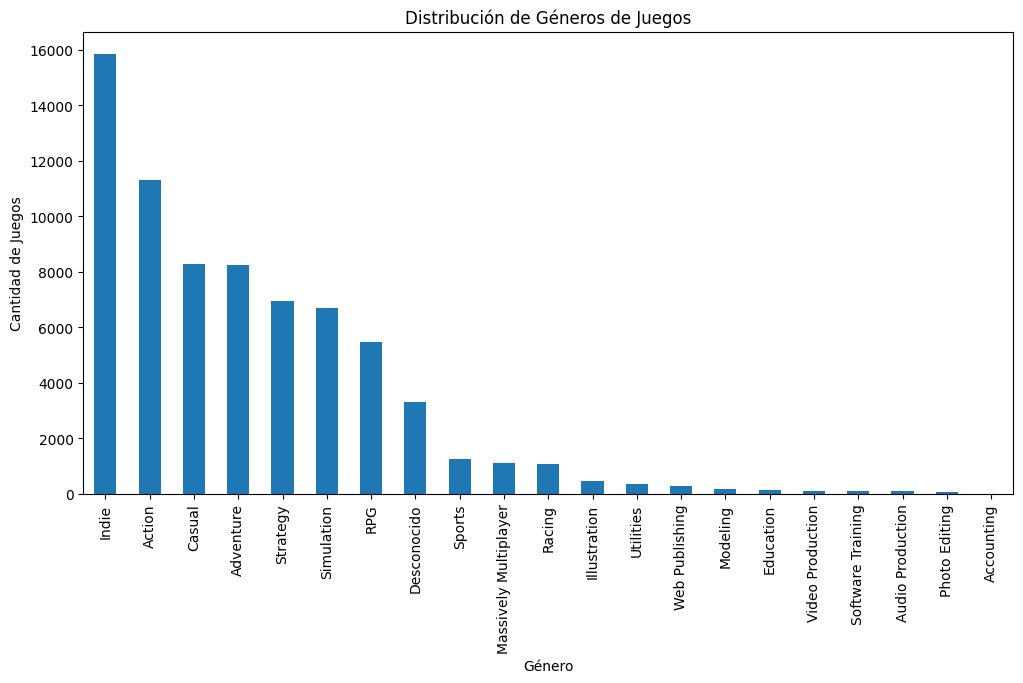

In [139]:
# Contar la cantidad de juegos por género
genre_counts = df_output_steam_json['genres'].str.split(', ').explode().value_counts()

# Graficar la distribución de géneros
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Distribución de Géneros de Juegos')
plt.xlabel('Género')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=90)
plt.show()

DISTRIBUCION DE PRECIOS DE JEUGOS

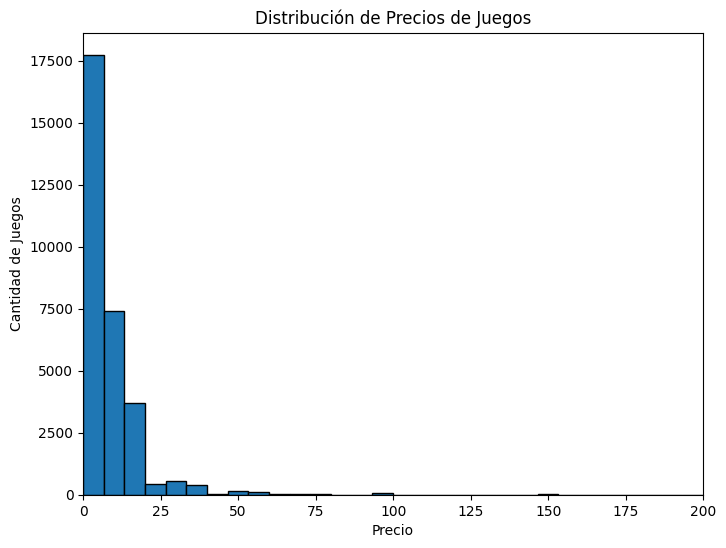

In [140]:
# Graficar la distribución de precios con rango personalizado
plt.figure(figsize=(8, 6))
plt.hist(df_output_steam_json['price'].dropna(), bins=30, range=(0, 200), edgecolor='k')
plt.title('Distribución de Precios de Juegos')
plt.xlabel('Precio')
plt.ylabel('Cantidad de Juegos')
plt.xlim(0, 200)
plt.show()

DESARROLLADORES MAS COMUNES

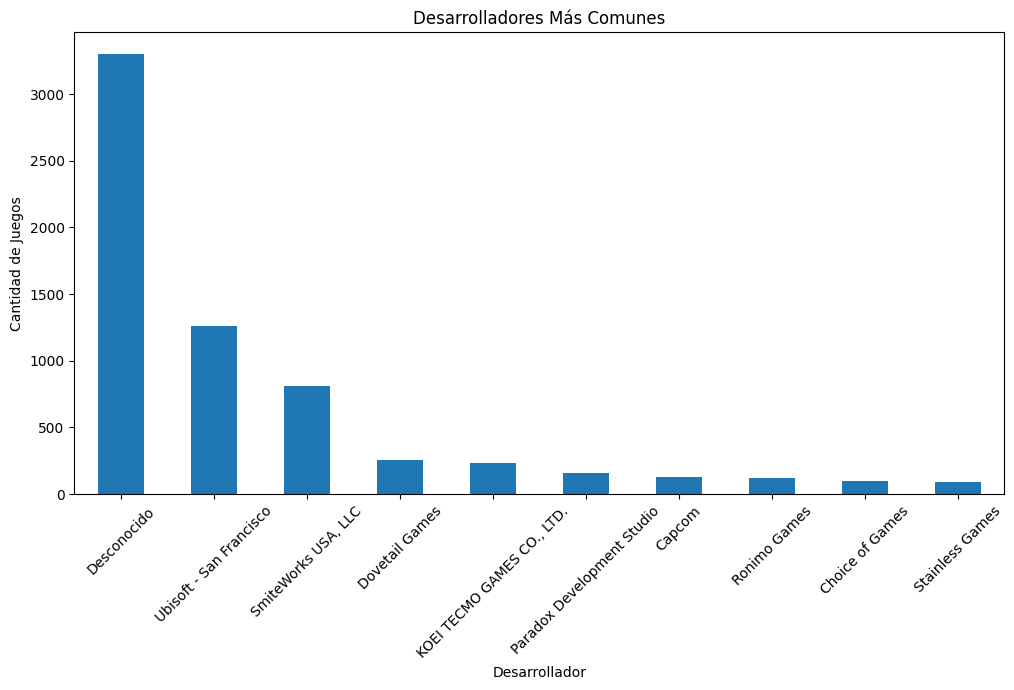

In [141]:
# Contar los desarrolladores más comunes
top_developers = df_output_steam_json['developer'].value_counts().head(10)

# Graficar los desarrolladores más comunes
plt.figure(figsize=(12, 6))
top_developers.plot(kind='bar')
plt.title('Desarrolladores Más Comunes')
plt.xlabel('Desarrollador')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=45)
plt.show()

ANALISIS POR YEAR

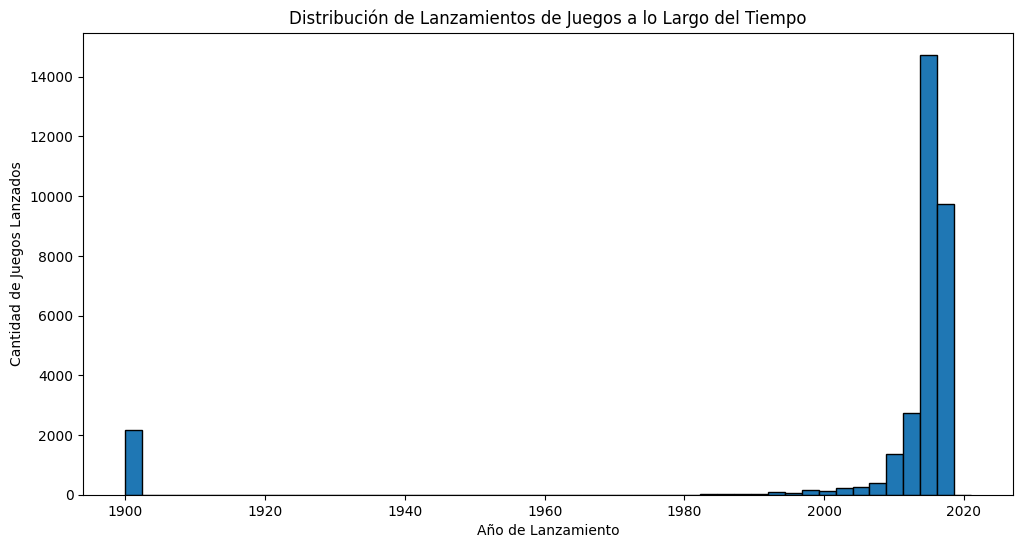

In [142]:
#hacemos una copia del df
df_output_steam_json_cp = df_output_steam_json.copy()

# Convertir la columna 'release_date' a tipo datetime
df_output_steam_json_cp['release_date'] = pd.to_datetime(df_output_steam_json_cp['release_date'], errors='coerce')

# Extraer el año de lanzamiento
df_output_steam_json_cp['release_year'] = df_output_steam_json_cp['release_date'].dt.year

# Filtrar valores inválidos
valid_years = df_output_steam_json_cp['release_year'][(df_output_steam_json_cp['release_year'] >= 1900) & (df_output_steam_json_cp['release_year'] <= 2023)]

# Graficar la distribución de lanzamientos a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.hist(valid_years, bins=50, edgecolor='k')
plt.title('Distribución de Lanzamientos de Juegos a lo Largo del Tiempo')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Cantidad de Juegos Lanzados')
plt.show()

OUTLIERS EN PRICE

In [143]:
# Ordenar el DataFrame por la columna 'price' de manera descendente
steam_games_sorted = df_output_steam_json.sort_values(by='price', ascending=False)

# Juego más caro
juego_mas_caro = steam_games_sorted.iloc[0]
id_juego_mas_caro = juego_mas_caro['item_id']
precio_juego_mas_caro = juego_mas_caro['price']

# Los 3 juegos más caros
tres_juegos_mas_caros = steam_games_sorted.iloc[:3]
ids_tres_juegos_mas_caros = tres_juegos_mas_caros['item_id'].tolist()
precios_tres_juegos_mas_caros = tres_juegos_mas_caros['price'].tolist()

print("Juego más caro (ID:", id_juego_mas_caro, "Precio:", precio_juego_mas_caro, "USD)")
print("\nLos 3 juegos más caros (IDs:", ids_tres_juegos_mas_caros, "Precios:", precios_tres_juegos_mas_caros, "USD)")


Juego más caro (ID: 719000 Precio: 995.0 USD)

Los 3 juegos más caros (IDs: [719000, 292180, 358040] Precios: [995.0, 771.71, 599.0] USD)


Outliers en la columna 'price' utilizando el método de 3 sigmas:
       item_id   price
18      774279   59.99
424      34270   61.99
1045    202170   74.76
1093    100980   99.99
1177    202970   59.99
...        ...     ...
30022   214950   59.95
30316   222282   79.99
30351   211500  160.91
30449   100400   99.99
30475   220700   69.99

[302 rows x 2 columns]


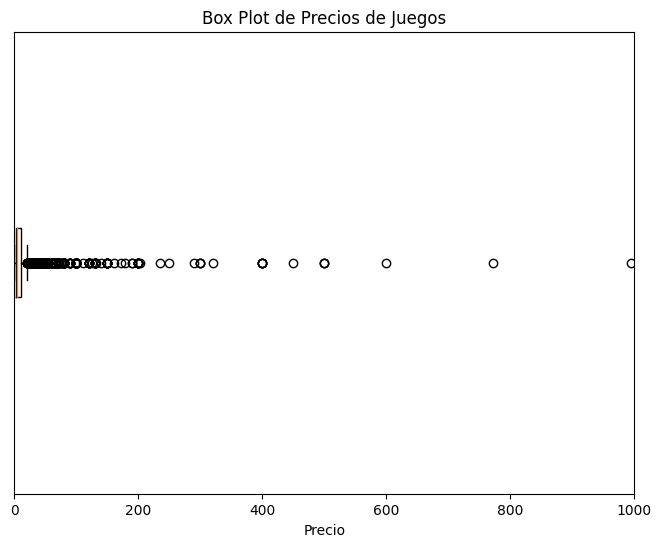

In [144]:
# Calcula la media y la desviación estándar de la columna 'price'
mean_price = df_output_steam_json['price'].mean()
std_price = df_output_steam_json['price'].std()

# Define los límites para identificar outliers utilizando el método de 3 sigmas
lower_limit = mean_price - 3 * std_price
upper_limit = mean_price + 3 * std_price

# Encuentra outliers
outliers = df_output_steam_json[(df_output_steam_json['price'] < lower_limit) | (df_output_steam_json['price'] > upper_limit)]

# Imprime los outliers
print("Outliers en la columna 'price' utilizando el método de 3 sigmas:")
print(outliers[['item_id', 'price']])

# Crear un box plot de la columna 'price'
plt.figure(figsize=(8, 6))
plt.boxplot(df_output_steam_json['price'].dropna(), vert=False)
plt.title('Box Plot de Precios de Juegos')
plt.xlabel('Precio')
plt.yticks([])
plt.xlim(0, 1000)  # ponemos este limite porque vimos antes que el maximo estaba en 995
plt.show()

.

.

# USER REVIEWS

In [145]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             59305 non-null  object
 1   posted              59305 non-null  object
 2   item_id             59305 non-null  int32 
 3   recommend           59305 non-null  int32 
 4   review              59305 non-null  object
 5   year                59305 non-null  int64 
 6   sentiment_analysis  59305 non-null  int32 
dtypes: int32(3), int64(1), object(3)
memory usage: 2.5+ MB


DISTRIBUCION DE SENTIMIENTOS

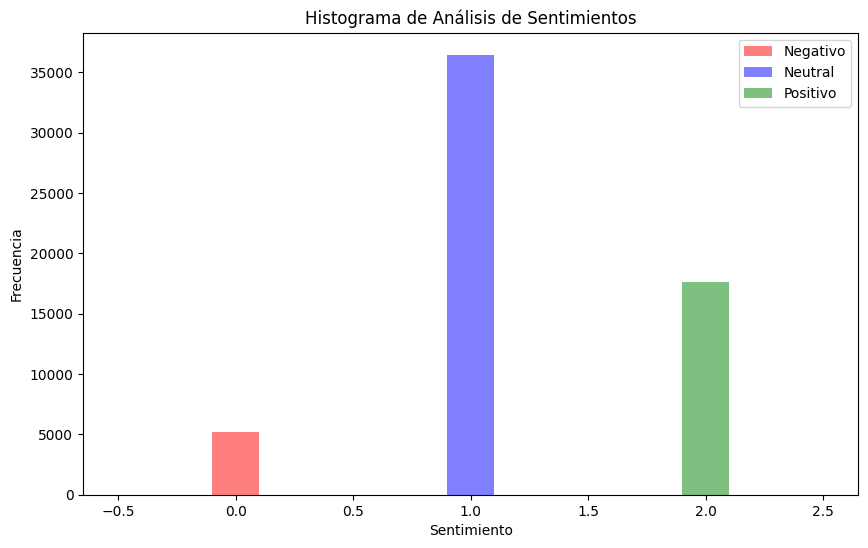

In [146]:
# Filtrar los dataframes por sentimiento (0, 1, 2)
sentiment_0 = df_user_reviews[df_user_reviews['sentiment_analysis'] == 0]
sentiment_1 = df_user_reviews[df_user_reviews['sentiment_analysis'] == 1]
sentiment_2 = df_user_reviews[df_user_reviews['sentiment_analysis'] == 2]

# Crear el histograma con tres sentimientos en el mismo gráfico
plt.figure(figsize=(10, 6))

plt.hist(sentiment_0['sentiment_analysis'], bins=5, color='red', alpha=0.5, label='Negativo')
plt.hist(sentiment_1['sentiment_analysis'], bins=5, color='blue', alpha=0.5, label='Neutral')
plt.hist(sentiment_2['sentiment_analysis'], bins=5, color='green', alpha=0.5, label='Positivo')

plt.title('Histograma de Análisis de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.legend()

plt.show()

DISTRIBUCION DE RECOMMEND

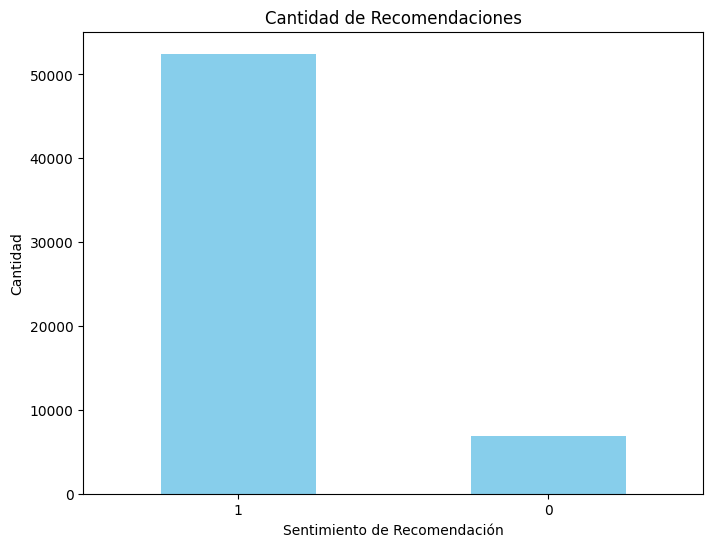

In [147]:
# Contar la cantidad de recomendaciones por categoría
recommend_counts = df_user_reviews['recommend'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
recommend_counts.plot(kind='bar', color='skyblue')

plt.title('Cantidad de Recomendaciones')
plt.xlabel('Sentimiento de Recomendación')
plt.ylabel('Cantidad')

plt.xticks(rotation=0)  # Rotar etiquetas del eje x

plt.show()

Diagrama de dispersión de análisis de sentimientos vs. tiempo de publicación:

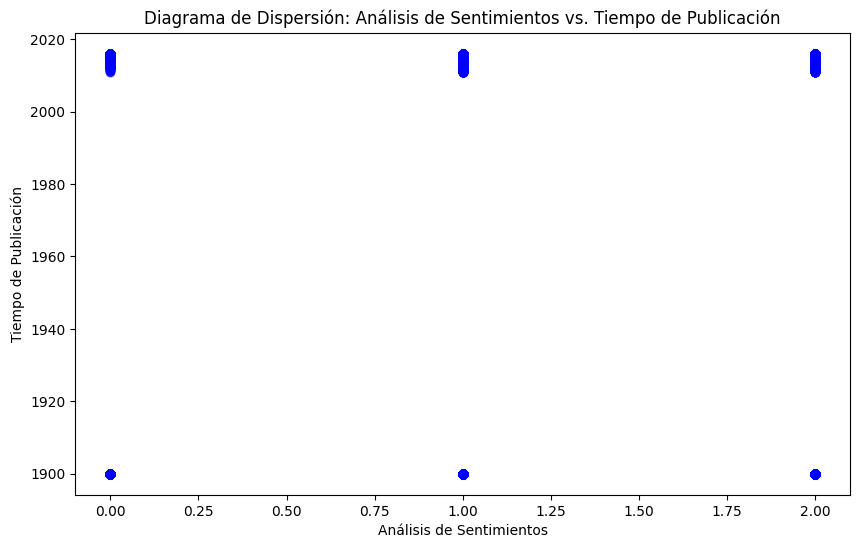

In [148]:
#Hacemos una copia del df
df_user_reviews_cp = df_user_reviews.copy()

# Asegurarse de que 'posted' esté en formato de fecha
df_user_reviews_cp['posted'] = pd.to_datetime(df_user_reviews_cp['posted'])

# Crear el diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_user_reviews_cp['sentiment_analysis'], df_user_reviews_cp['posted'], alpha=0.2, color='b')

plt.title('Diagrama de Dispersión: Análisis de Sentimientos vs. Tiempo de Publicación')
plt.xlabel('Análisis de Sentimientos')
plt.ylabel('Tiempo de Publicación')

plt.show()

PALABRAS MAS COMUNES

In [149]:
import nltk
from nltk.corpus import stopwords


In [150]:
# Descargar la lista de stop words si no la tienes
#nltk.download('stopwords')

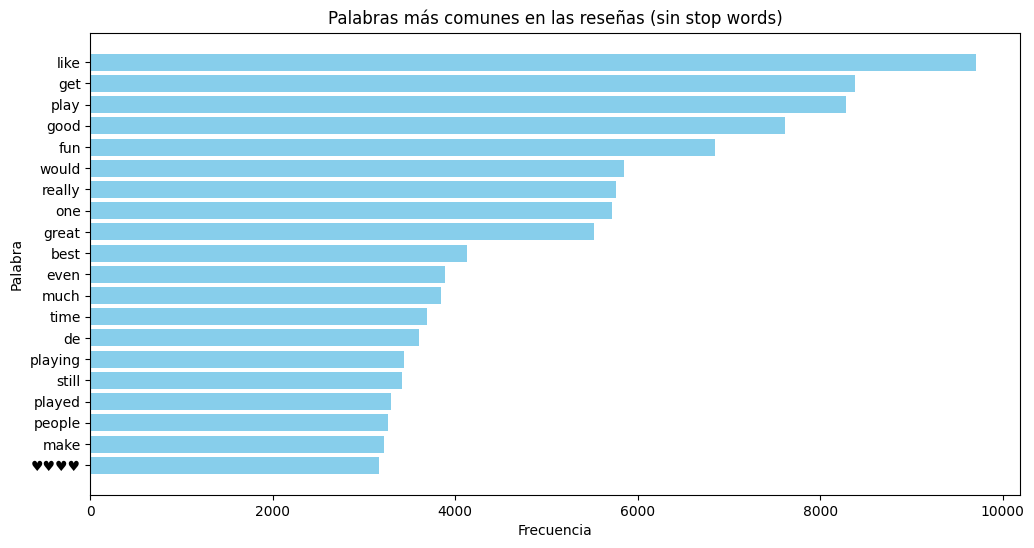

In [151]:
from collections import Counter
from wordcloud import WordCloud


# Cargar la lista de stop words en inglés
stop_words = set(stopwords.words('english'))


# Agregar "game" como stop word adicional
stop_words.add("game")
stop_words.add("game.")
stop_words.add("game,")
stop_words.add("games")

# Unir todas las reseñas en un solo texto
all_reviews = ' '.join(df_user_reviews['review'].astype(str))

# Tokenizar las palabras y eliminar stop words
words = all_reviews.split()
filtered_words = [word for word in words if word.lower() not in stop_words]

# Contar la frecuencia de las palabras filtradas
word_freq = Counter(filtered_words)

# Obtener las palabras más comunes (por ejemplo, las 20 más comunes)
common_words = word_freq.most_common(20)

# Crear un DataFrame para facilitar la visualización
common_words_df = pd.DataFrame(common_words, columns=['Palabra', 'Frecuencia'])

# Crear un gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(common_words_df['Palabra'], common_words_df['Frecuencia'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras más comunes en las reseñas (sin stop words)')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar las palabras más comunes en la parte superior
plt.show()

# USER ITEMS

In [152]:
df_user_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110819 entries, 0 to 5110818
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          object 
 3   user_url          object 
 4   item_id           int32  
 5   item_name         object 
 6   playtime_forever  float64
 7   playtime_2weeks   float64
dtypes: float64(2), int32(1), int64(1), object(4)
memory usage: 292.4+ MB


Histograma de tiempo de juego (playtime_forever)

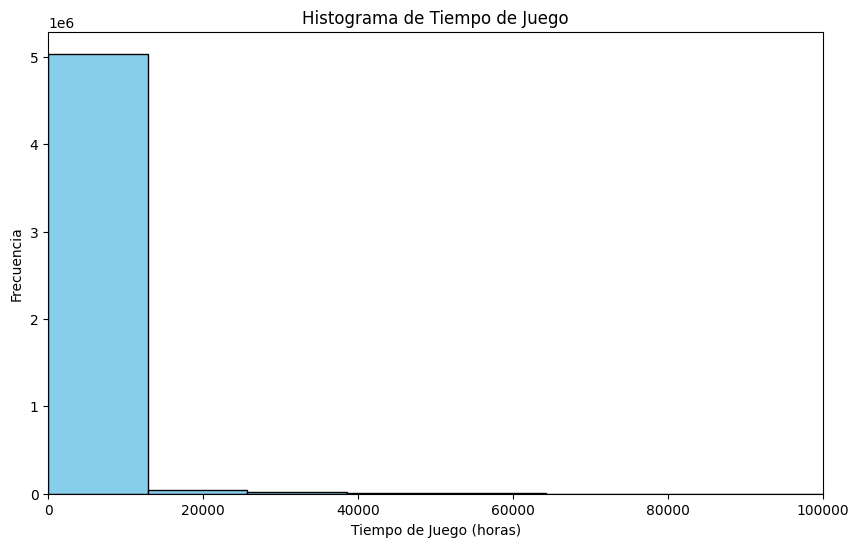

In [153]:
plt.figure(figsize=(10, 6))
plt.hist(df_user_items['playtime_forever'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Tiempo de Juego (horas)')
plt.ylabel('Frecuencia')
plt.title('Histograma de Tiempo de Juego')
plt.xlim(0, 100000)
plt.show()

Gráfico de barras de los juegos más jugados:

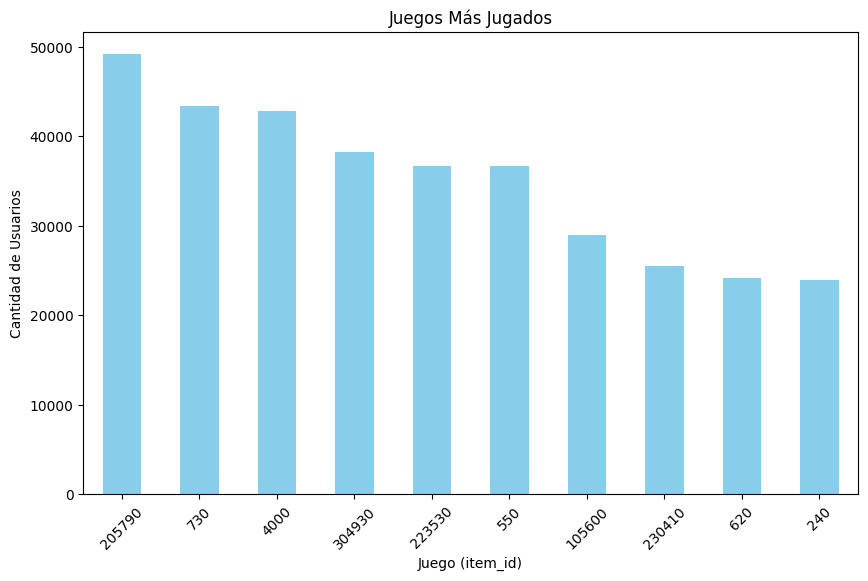

In [154]:
top_played_games = df_user_items['item_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_played_games.plot(kind='bar', color='skyblue')
plt.xlabel('Juego (item_id)')
plt.ylabel('Cantidad de Usuarios')
plt.title('Juegos Más Jugados')
plt.xticks(rotation=45)
plt.show()


Gráfico de barras de la cantidad de juegos por usuario:

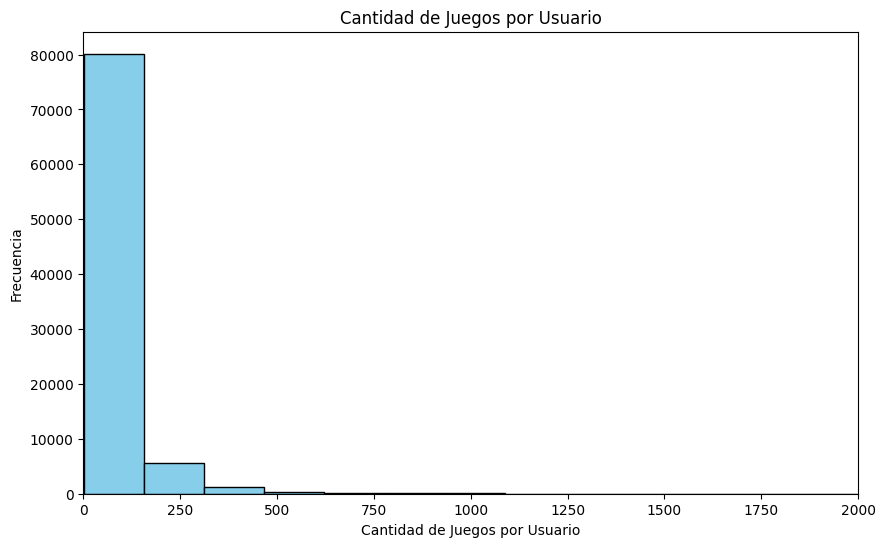

In [155]:
games_per_user = df_user_items['user_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(games_per_user, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Cantidad de Juegos por Usuario')
plt.ylabel('Frecuencia')
plt.title('Cantidad de Juegos por Usuario')
plt.xlim(0, 2000)
plt.show()

Diagrama de dispersión de tiempo de juego vs. número de juegos por usuario:

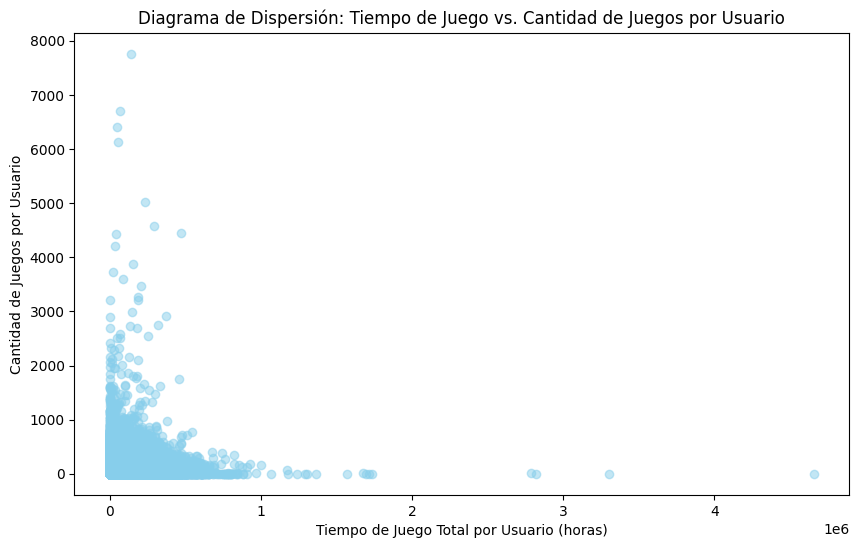

In [156]:
plt.figure(figsize=(10, 6))
plt.scatter(df_user_items.groupby('user_id')['playtime_forever'].sum(), games_per_user, alpha=0.5, color='skyblue')
plt.xlabel('Tiempo de Juego Total por Usuario (horas)')
plt.ylabel('Cantidad de Juegos por Usuario')
plt.title('Diagrama de Dispersión: Tiempo de Juego vs. Cantidad de Juegos por Usuario')
plt.show()

JUEGO MAS JUGADO

In [157]:
most_played_game = df_user_items.groupby('item_id')['playtime_forever'].sum().idxmax()
most_played_hours = df_user_items.groupby('item_id')['playtime_forever'].sum().max()

print(f"El juego más jugado es el item_id {most_played_game} con {most_played_hours} horas jugadas.")


El juego más jugado es el item_id 730 con 775918724.0 horas jugadas.


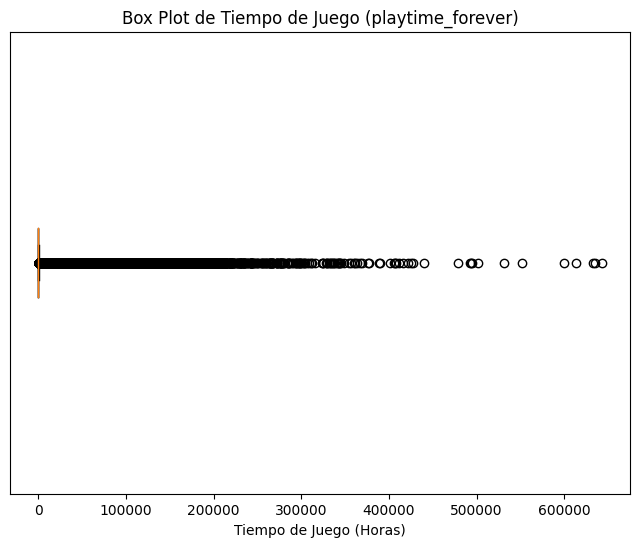

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot(df_user_items['playtime_forever'].dropna(), vert=False)
plt.title('Box Plot de Tiempo de Juego (playtime_forever)')
plt.xlabel('Tiempo de Juego (Horas)')
plt.yticks([])
plt.show()


.

.

.

# GENERACION DE ARCHIVOS REDUCIDOS PARA C/ ENDPOINT

EN ESTA ETAPA CREARE ARCHIVOS REDUCIDOS PARA SER CONSUMIDOS POR LA API. EL OBJETIVO DE ESTO ES QUE LA API NO TENGA QUE APLICAR UNA LOGICA COMPLEJA, SINO MAS BIEN UNA LOGICA DE CONSULTA A ESTOS ARCHIVOS REDUCIDOS.

COMO RESULTADO HEMOS OBTENIDO EXCELENTE DESEMPEÑO EN EL TIEMPO DE RESPUESTA DE TODOS LOS ENDPOINT DE LA API

.

.

1) **<u> def userdata( User_id : str ):</u>**

    Debe devolver cantidad de dinero gastado por el usuario, 
    el porcentaje de recomendación en base a reviews.recommend y 
    cantidad de items.

CREAREMOS 3 DFs REDUCIDOS PARA LUEGO UNIRLOS EN UNO SOLO A NIVEL DE USER_ID

In [159]:
#Usuarios Unicos
df_user_items["user_id"].unique().shape[0]

87626

.

**<u>df_price_by_user:</u>**   Va a ser un DF agrupado por user_id con la sumatoria de todos los gastos (price) efectuados por ese usuario.

.

In [160]:
#Creamos DF vacio
df_spent_by_user = pd.DataFrame()

#Agrego Columna de user_id
df_spent_by_user["user_id"] = df_user_items["user_id"].unique()

#verifico cantidad de registros
df_spent_by_user.shape[0]

87626

In [161]:
#Creamos un DataFrame entre steam y users para tener el precio a nivel item_id
df_merged_items_steam_by_itemid = df_user_items.merge(df_output_steam_json, on='item_id', how='left')
#Por las dudas convertimos a float la columna precio
df_merged_items_steam_by_itemid['price'] = df_merged_items_steam_by_itemid['price'].astype(float)

df_merged_items_steam_by_itemid.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks,genres,release_date,price,developer,year
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0,Action,2000-11-01,9.99,Valve,2000.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0,Action,1999-04-01,4.99,Valve,1999.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0,Action,2003-05-01,4.99,Valve,2003.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0,Action,2001-06-01,4.99,Valve,2001.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0,Action,1999-11-01,4.99,Gearbox Software,1999.0


In [162]:
#Total de Gastos/price (sum) por usuario
df_spent_by_user = pd.merge(df_spent_by_user, df_merged_items_steam_by_itemid.groupby('user_id')['price'].sum().reset_index(), on='user_id', how='left')
#Modificamos el nombre de la columna calculada
df_spent_by_user.rename(columns={"price": "spent"}, inplace=True)
#Visualizamos el df
df_spent_by_user.head()

,user_id,spent
0,76561197970982479,3424.31
1,js41637,8553.07
2,evcentric,1584.90
3,Riot-Punch,3377.22
4,doctr,6760.32


.



**<u>df_perc_recommend_by_user:</u>**   Va a ser un DF agrupado por user_id el porcentaje de recomendaciones POSITIVAS(1) en funcion de las NEGATIVAS(0).

.



In [163]:
#Creamos un DF vacio
df_perc_recommend_by_user = pd.DataFrame()

#Agrego Columna de user_id
df_perc_recommend_by_user["user_id"] = df_user_items["user_id"].unique()

#verifico cantidad de registros
df_perc_recommend_by_user.shape[0]

87626

In [164]:
#Recomendaciones Negativas
df_recommend_0 = df_user_reviews[df_user_reviews['recommend'] == 0].groupby('user_id')['recommend'].count().reset_index()
df_recommend_0.rename(columns={"recommend": "recommend_0"}, inplace=True)
#Recomendaciones positivas
df_recommend_1 = df_user_reviews[df_user_reviews['recommend'] == 1].groupby('user_id')['recommend'].count().reset_index()
df_recommend_1.rename(columns={"recommend": "recommend_1"}, inplace=True)

#Combinamos ambos DFs
df_recommend = pd.merge(df_recommend_0,df_recommend_1, on='user_id', how='inner')

#Actuaslizamos los valores nulos
df_recommend['recommend_0'].fillna(0, inplace=True)
df_recommend['recommend_1'].fillna(0, inplace=True)

# Convierte las columnas 'recommend_0' y 'recommend_1' a enteros
df_recommend['recommend_0'] = df_recommend['recommend_0'].astype(int)
df_recommend['recommend_1'] = df_recommend['recommend_1'].astype(int)


#Calculamos el total de recomendaciones por usuario en una nueva columna, sumando las positivas y negativas
df_recommend['recommend_total'] = df_recommend['recommend_0'] + df_recommend['recommend_1']
df_recommend['recommend_total'] = df_recommend['recommend_total'].astype(int)


#Calculamos el porcentaje con las columnas anteriores
df_recommend['perc_recommend'] = 0  # Inicializa la columna con ceros
df_recommend['perc_recommend'] = df_recommend['perc_recommend'].astype(float)

nonzero_total_mask = df_recommend['recommend_total'] != 0 #Crea Mascara, porque sino podriamos generar una division por cero. 
df_recommend.loc[nonzero_total_mask, 'perc_recommend'] = (df_recommend['recommend_1'] / df_recommend['recommend_total']) * 100

#Quitamos intermedias
#df_recommend.drop(['recommend_0', 'recommend_1', 'recommend_total'], axis=1, inplace=True)


In [165]:
df_recommend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3684 entries, 0 to 3683
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3684 non-null   object 
 1   recommend_0      3684 non-null   int32  
 2   recommend_1      3684 non-null   int32  
 3   recommend_total  3684 non-null   int32  
 4   perc_recommend   3684 non-null   float64
dtypes: float64(1), int32(3), object(1)
memory usage: 100.9+ KB


In [166]:
df_recommend.shape

(3684, 5)

In [167]:
df_recommend.head()

,user_id,recommend_0,recommend_1,recommend_total,perc_recommend
0,-GM-Dragon,1,1,2,50.000000
1,-PRoSlayeR-,1,1,2,50.000000
2,-SEVEN-,2,7,9,77.777778
3,-_PussyDestroyer_-,2,3,5,60.000000
4,00454211432342,1,1,2,50.000000


In [168]:
#Juntamos con nuestro "maestro" de user_id el df anterior
df_perc_recommend_by_user = pd.merge(df_perc_recommend_by_user,df_recommend, on='user_id', how='left')

# Reemplaza los valores nulos por ceros 
df_perc_recommend_by_user['recommend_0'].fillna(0, inplace=True)
df_perc_recommend_by_user['recommend_1'].fillna(0, inplace=True)
df_perc_recommend_by_user['recommend_total'].fillna(0, inplace=True)
df_perc_recommend_by_user['perc_recommend'].fillna(0, inplace=True)

# Convierte el tipo de dato de la columna 'perc_recommend' a float
df_perc_recommend_by_user['recommend_0'] = df_perc_recommend_by_user['recommend_0'].astype(float)
df_perc_recommend_by_user['recommend_1'] = df_perc_recommend_by_user['recommend_1'].astype(float)
df_perc_recommend_by_user['recommend_total'] = df_perc_recommend_by_user['recommend_total'].astype(float)
df_perc_recommend_by_user['perc_recommend'] = df_perc_recommend_by_user['perc_recommend'].astype(float)

In [169]:
df_perc_recommend_by_user.head()

,user_id,recommend_0,recommend_1,recommend_total,perc_recommend
0,76561197970982479,0.0,0.0,0.0,0.0
1,js41637,0.0,0.0,0.0,0.0
2,evcentric,0.0,0.0,0.0,0.0
3,Riot-Punch,0.0,0.0,0.0,0.0
4,doctr,0.0,0.0,0.0,0.0


.


**<u>df_cant_items_by_user:</u>**   Va a ser un DF agrupado por user_id Con la cantidad de items de cada user.

.

In [170]:
#Creamos un DF vacio
df_count_items_by_user = pd.DataFrame()

#Agrego Columna de user_id
df_count_items_by_user["user_id"] = df_user_items["user_id"].unique()

#verifico cantidad de registros
df_count_items_by_user.shape[0]

87626

In [171]:
#Agregamos la columna de cantidad de items
df_count_items_by_user = pd.merge(df_count_items_by_user, df_user_items.groupby('user_id')['item_id'].count().reset_index(), on='user_id', how='left')
#Modificamos el nombre de la columna calculada
df_count_items_by_user.rename(columns={"item_id": "count_items"}, inplace=True)
# Reemplaza los valores nulos por ceros 
df_count_items_by_user['count_items'].fillna(0, inplace=True)
# Convierte el tipo de dato de la columna 'perc_recommend' a float
df_count_items_by_user['count_items'] = df_count_items_by_user['count_items'].astype(int)
#Visualizamos el DF
df_count_items_by_user.head()

,user_id,count_items
0,76561197970982479,277
1,js41637,888
2,evcentric,137
3,Riot-Punch,328
4,doctr,541


UNIMOS LOS DFs

In [226]:
# Unir los DataFrames en uno solo usando la columna "user_id" como clave
df_user_data = df_spent_by_user.merge(df_perc_recommend_by_user, on='user_id', how='outer')
df_user_data = df_user_data.merge(df_count_items_by_user, on='user_id', how='outer')
# Eliminar las columnas del DataFrame
df_user_data = df_user_data.drop(["recommend_0", "recommend_1", "recommend_total"], axis=1)
#casteamos por las dudas
df_user_data['spent'] = df_user_data['spent'].astype(float)
df_user_data['perc_recommend'] = df_user_data['perc_recommend'].astype(float)
df_user_data['count_items'] = df_user_data['count_items'].astype(int)

df_user_data.head()

,user_id,spent,perc_recommend,count_items
0,76561197970982479,3424.31,0.0,277
1,js41637,8553.07,0.0,888
2,evcentric,1584.90,0.0,137
3,Riot-Punch,3377.22,0.0,328
4,doctr,6760.32,0.0,541


EXPORTAMOS LOS 3 DFs EN formato JSON.GZ

In [227]:
#Exportamos los data frame
#grabarJsonGz(df_spent_by_user,'spent_by_user')
#grabarJsonGz(df_perc_recommend_by_user,'perc_recommend_by_user')
#grabarJsonGz(df_count_items_by_user,'count_items_by_user')
grabarJsonGz(df_user_data,'user_data')

.

.


.

2) **<u>def countreviews( YYYY-MM-DD y YYYY-MM-DD : str ): </u>**

    Cantidad de usuarios que realizaron reviews entre las fechas dadas y, 
    el porcentaje de recomendación de los mismos en base a reviews.recommend.

CREAREMOS 2 DFs REDUCIDOS (COMO SI FUESEN  VISTAS) para cada solicitud del ENDPOINT

df_user_reviews_posted

df_perc_recommend_by_user (creado para el Endo Point Anterior)

In [173]:
df_user_reviews_posted = df_user_reviews[['user_id','item_id','posted','recommend']]
df_user_reviews_posted.head()

,user_id,item_id,posted,recommend
0,76561197970982479,1250,2011-11-05,1
1,76561197970982479,22200,2011-07-15,1
2,76561197970982479,43110,2011-04-21,1
3,js41637,251610,2014-06-24,1
4,js41637,227300,2013-09-08,1


In [174]:
df_user_reviews_posted.shape[0]

59305

In [175]:
#Exportamos los data frame
grabarJsonGz(df_user_reviews_posted,'user_reviews_posted')

.

.


.

3) **<u>def genre ( género : str ):</u>**  

    Devuelve el puesto en el que se encuentra un género sobre el ranking de los mismos analizado bajo la columna PlayTimeForever.

In [176]:
df_user_items[['item_id','playtime_forever']]

,item_id,playtime_forever
0,10,6.0
1,20,0.0
2,30,7.0
3,40,0.0
4,50,0.0
...,...,...
5110814,373330,0.0
5110815,388490,3.0
5110816,521570,4.0
5110817,519140,3.0


In [177]:
# Contar la cantidad máxima de géneros por 'item_id'
max_genres_count = df_output_steam_json['genres'].str.count(',').max() + 1  # Agregar 1 para contar el primer género

print("La cantidad máxima de géneros por 'item_id' es:", max_genres_count)

La cantidad máxima de géneros por 'item_id' es: 10


In [178]:
df_output_steam_json[df_output_steam_json['genres'] == '']

,item_id,genres,release_date,price,developer,year


In [179]:
# Dividir la columna 'genres' en géneros individuales y crear un conjunto de géneros únicos
unique_genres_set = set(df_output_steam_json['genres'].str.split(',').explode().str.strip())

# Convertir el conjunto de géneros únicos en una lista
unique_genres_list = list(unique_genres_set)

# Mostrar la lista de géneros únicos
print(unique_genres_list)
print(len(unique_genres_list))

['Utilities', 'Education', 'Video Production', 'Audio Production', 'Photo Editing', 'Indie', 'Software Training', 'Accounting', 'Massively Multiplayer', 'Desconocido', 'Casual', 'Web Publishing', 'Simulation', 'Strategy', 'Illustration', 'RPG', 'Modeling', 'Sports', 'Action', 'Adventure', 'Racing']
21


In [180]:
# Elimina filas con valores NaN en la columna 'item_id'
df_user_items_tmp = df_user_items.dropna(subset=['item_id'])

# Asegurarse de que la columna 'item_id' sea de tipo int64
df_user_items_tmp.loc[:, 'item_id'] = df_user_items_tmp['item_id'].astype(int)

# Paso 1: Dividir la columna 'genres' en géneros individuales
df_genres_split = df_output_steam_json['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('genre').str.strip()

# Paso 2: Unir los DataFrames utilizando 'item_id'
df_merged = df_user_items_tmp.merge(df_genres_split, left_on='item_id', right_index=True)

# Paso 3: Calcular el ranking de géneros en función de 'playtime_forever'
genre_ranking = df_merged.groupby('genre')['playtime_forever'].sum().reset_index()

# Ordenar el DataFrame en función del tiempo total de juego en orden descendente
genre_ranking = genre_ranking.sort_values(by='playtime_forever', ascending=False)

#Reseteamos indices
genre_ranking.reset_index(drop=True, inplace=True)

# Mostrar el ranking de géneros
genre_ranking.head(10)

,genre,playtime_forever
0,Strategy,957670455.0
1,Indie,767750833.0
2,Adventure,653948406.0
3,Casual,554222120.0
4,Action,277435494.0
5,Desconocido,158335784.0
6,Simulation,117841298.0
7,RPG,71389306.0
8,Massively Multiplayer,28067218.0
9,Sports,6582462.0


In [181]:
genre_ranking.shape[0]

19

In [182]:
genre_ranking['genre'].unique()

array(['Strategy', 'Indie', 'Adventure', 'Casual', 'Action',
       'Desconocido', 'Simulation', 'RPG', 'Massively Multiplayer',
       'Sports', 'Racing', 'Illustration', 'Modeling', 'Web Publishing',
       'Education', 'Software Training', 'Utilities', 'Audio Production',
       'Photo Editing'], dtype=object)

In [183]:
#Creamos un DF vacio
df_genre_ranking = pd.DataFrame()

# Reiniciar el índice y agregar una nueva columna de ranking
df_genre_ranking = genre_ranking[['genre']].reset_index(drop=True)

# Renombrar la columna de ranking
df_genre_ranking.rename(columns={'index': 'ranking'}, inplace=True)


In [184]:
#Exportamos los data frame
grabarJsonGz(df_genre_ranking,'genre_ranking')

.

.

.

4) **<u>def userforgenre ( género : str ):</u>**  

    Top 5 de usuarios con más horas de juego en el género dado, con su URL (del user) y user_id.

In [185]:
# Dividir la columna genres en múltiples filas
df_genres_split = df_output_steam_json['genres'].str.split(',').explode().str.strip()

# Unir los DataFrames para obtener toda la información necesaria
df_user_genre_ranking = df_user_items.merge(df_genres_split.to_frame(), left_on='item_id', right_index=True)

# Calcular la suma de playtime_forever por género y usuario
df_user_genre_ranking = df_user_genre_ranking.groupby(['genres', 'user_id', 'user_url'])['playtime_forever'].sum().reset_index()

# Ordenar por género y playtime_forever en orden descendente
df_user_genre_ranking = df_user_genre_ranking.sort_values(['genres', 'playtime_forever'], ascending=[True, False])

# Mantener solo las 5 mejores filas por género
df_user_genre_ranking = df_user_genre_ranking.groupby('genres').head(5)

# Reiniciar el índice
df_user_genre_ranking = df_user_genre_ranking.reset_index(drop=True)

# Renombrar las columnas para que coincidan con la salida deseada
df_user_genre_ranking = df_user_genre_ranking.rename(columns={'genres': 'genre'})

# Mostrar el DataFrame resultante
df_user_genre_ranking[['genre', 'user_id', 'user_url', 'playtime_forever']].head()

,genre,user_id,user_url,playtime_forever
0,Action,stopgovtcorruption,http://steamcommunity.com/id/stopgovtcorruption,594327.0
1,Action,SuNNZ,http://steamcommunity.com/id/SuNNZ,485086.0
2,Action,ILDHAM123,http://steamcommunity.com/id/ILDHAM123,389495.0
3,Action,76561197969956494,http://steamcommunity.com/profiles/76561197969...,389399.0
4,Action,mittensgalore,http://steamcommunity.com/id/mittensgalore,388665.0


In [186]:
#Exportamos los data frame
grabarJsonGz(df_user_genre_ranking,'user_genre_ranking')

.

.

.

5) **<u>def developer( desarrollador : str ): </u>**  

    Cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora. Ejemplo de salida:

In [187]:
# Crear un nuevo DataFrame con el nombre df_output_steam_tmp copiando df_output_steam_json
df_output_steam_tmp = df_output_steam_json.copy()

# Extraer el año de la columna 'release_date'
df_output_steam_tmp['year'] = df_output_steam_tmp['release_date'].str[:4]

# Convertir la columna 'year' a tipo numérico
df_output_steam_tmp['year'] = pd.to_numeric(df_output_steam_tmp['year'], errors='coerce')

# Filtrar los registros con año igual a 1900
df_output_steam_tmp = df_output_steam_tmp[df_output_steam_tmp['year'] != 1900]

# Calcular 'items_count' por desarrollador y año
developer_items_count = df_output_steam_tmp.groupby(['developer', 'year'])['item_id'].count().reset_index()
developer_items_count.rename(columns={'item_id': 'items_count'}, inplace=True)

# Calcular 'free_content' por desarrollador y año
developer_free_games = df_output_steam_tmp[df_output_steam_tmp['price'] == 0].groupby(['developer', 'year'])['item_id'].count().reset_index()
developer_free_games.rename(columns={'item_id': 'free_count'}, inplace=True)

# Combinar los DataFrames para calcular el porcentaje
df_content_developer = developer_items_count.merge(developer_free_games, on=['developer', 'year'], how='left')
df_content_developer['free_content'] = (df_content_developer['free_count'] / df_content_developer['items_count']) * 100
df_content_developer.drop(columns=['free_count'], inplace=True)

#Si no encuentra elementos con precio 0, ese registro va a quedar con Nan cuando deberia ser cero.
df_content_developer['free_content'].fillna(0, inplace=True)

# Visualizamos
df_content_developer.head()

,developer,year,items_count,free_content
0,+7 Software,2016,1,0.0
1,"+Mpact Games, LLC.",2017,1,0.0
2,.M.Y.W.,2016,1,0.0
3,.ez Games,2017,1,0.0
4,07th Expansion,2015,2,0.0


In [188]:
#Exportamos los data frame
grabarJsonGz(df_content_developer,'content_developer')

.

.

.

6) **<u>def sentiment_analysis( año : int ): </u>**  

    Según el año de lanzamiento, se devuelve una lista con la cantidad de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento.

In [189]:
# Crear el DataFrame df_review_year con la columna 'year'
df_reviews_year = df_output_steam_json[['year']].drop_duplicates().copy()

# Agrupa y suma los valores de sentiment_analysis en df_user_reviews por año
sentiment_year = df_user_reviews.groupby(['year', 'sentiment_analysis'])['sentiment_analysis'].count().unstack(fill_value=0).reset_index()

# Agregar las columnas 'Negativos', 'Neutros' y 'Positivos' en df_review_year
df_reviews_year = df_reviews_year.merge(sentiment_year, on='year', how='left')

# Cambiar los nombres de las columnas para mayor claridad
df_reviews_year.rename(columns={0: 'Negativos', 1: 'Neutros', 2: 'Positivos'}, inplace=True)

# Llenar NaN con 0 en las columnas 'Negativos', 'Neutros' y 'Positivos'
df_reviews_year.fillna(0, inplace=True)

# Convertir las columnas 'Negativos', 'Positivos' y 'Neutros' a enteros
df_reviews_year['Negativos'] = df_reviews_year['Negativos'].astype(int)
df_reviews_year['Positivos'] = df_reviews_year['Positivos'].astype(int)
df_reviews_year['Neutros']   = df_reviews_year['Neutros'].astype(int)

In [190]:
df_reviews_year.shape

(44, 4)

In [191]:
df_reviews_year.head(20)

,year,Negativos,Neutros,Positivos
0,2018,0,0,0
1,2017,0,0,0
2,1900,1000,6569,2550
3,1997,0,0,0
4,1998,0,0,0
5,2016,0,0,0
6,2006,0,0,0
7,2005,0,0,0
8,2003,0,0,0
9,2007,0,0,0


In [192]:
df_reviews_year[(df_reviews_year['Negativos'] != 0) | (df_reviews_year['Positivos'] != 0) | (df_reviews_year['Neutros'] != 0)].head()

,year,Negativos,Neutros,Positivos
2,1900,1000,6569,2550
23,2010,4,37,25
24,2011,41,269,222
25,2013,484,3883,2425
26,2012,80,638,497


In [193]:
#Años con reviews
df_reviews_year[(df_reviews_year['Negativos'] != 0) | (df_reviews_year['Positivos'] != 0) | (df_reviews_year['Neutros'] != 0)]['year'].unique()

array([1900, 2010, 2011, 2013, 2012, 2014, 2015], dtype=int64)

In [194]:
#Exportamos los data frame
grabarJsonGz(df_reviews_year,'reviews_year')

.

.

.

# MACHINE LEARNING

En el primer modelo que desarrollamos, creamos un Sistema de Recomendación de Juegos en Steam basado en el análisis de las características de los juegos. Utilizamos un enfoque de **Filtrado Basado en Contenido**, donde cada juego se describía en función de dos características clave: los **géneros** a los que pertenecía y el **análisis de sentimiento**, que reflejaba si las reseñas de los usuarios eran positivas, neutras o negativas.

Luego, construimos una Matriz de Características que representaba la relación entre los juegos y estas dos características. Esta matriz nos permitió calcular la similitud entre los juegos en función de sus géneros y análisis de sentimiento. Para medir la similitud, utilizamos medidas como la similitud coseno, que nos ayudaron a identificar los juegos más cercanos en términos de géneros y sentimientos similares.

El objetivo principal era proporcionar a los usuarios recomendaciones personalizadas de juegos similares a uno que ingresaran como parámetro.

Por ultimo, cabe destacar que no fue requerido ESCALAR los datos pese a usar distancias en en calculo de la similitud coseno. Los **géneros** de juegos y el **análisis de sentimiento** son datos **categóricos y ordinales**, respectivamente. No necesitan escalado porque no tienen una relación de orden continua y se manejan adecuadamente en el modelo de recomendación basado en contenido.

.

.

# MODELO DE RECOMENDACION ITEM-ITEM

In [195]:
df_output_steam_json.head()

,item_id,genres,release_date,price,developer,year
0,761140,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99,Kotoshiro,2018
1,643980,"Indie, RPG, Strategy",2018-01-04,0.00,Secret Level SRL,2018
2,670290,"Casual, Indie, Simulation, Sports",2017-07-24,0.00,Poolians.com,2017
3,767400,"Action, Adventure, Casual",2017-12-07,0.99,彼岸领域,2017
4,773570,Desconocido,1900-01-01,2.99,Desconocido,1900


In [196]:
df_user_reviews.head()

,user_id,posted,item_id,recommend,review,year,sentiment_analysis
0,76561197970982479,2011-11-05,1250,1,Simple yet with great replayability. In my opi...,2011,1
1,76561197970982479,2011-07-15,22200,1,It's unique and worth a playthrough.,2011,2
2,76561197970982479,2011-04-21,43110,1,Great atmosphere. The gunplay can be a bit chu...,2011,1
3,js41637,2014-06-24,251610,1,I know what you think when you see this title ...,2014,1
4,js41637,2013-09-08,227300,1,For a simple (it's actually not all that simpl...,2013,1


In [197]:
df_user_items.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


.

.


# PREPARACION DE LOS DATOS

.


VAMOS A GENERAR UN ARCHIVO QUE SERA UTILIZADO COMO INPUT EN NUESTRO MODELO DE MACHINE LEARNING (RECOMENDACION)

.


In [198]:
# Filtrar columnas relevantes de cada conjunto de datos para el modelo de RECOMENDACION
df_steam_recomendacion   = df_output_steam_json[['item_id', 'genres']]
df_reviews_recomendacion = df_user_reviews[['user_id', 'item_id', 'sentiment_analysis']]
#En este caso eliminamos los registros que teniamos sin item-id, a los cuales les imputamos -1
df_items_recomendacion = df_user_items[df_user_items['item_id'] != -1][['user_id', 'item_id']]

In [199]:
# Fusionar los datos en un solo conjunto
merged_data = df_reviews_recomendacion.merge(df_items_recomendacion, on=['user_id', 'item_id'], how='inner')
merged_data = merged_data.merge(df_steam_recomendacion, on='item_id', how='left')

In [200]:
merged_data.head()

,user_id,item_id,sentiment_analysis,genres
0,76561197970982479,1250,1,Action
1,76561197970982479,22200,2,"Action, Indie"
2,76561197970982479,43110,1,NaN
3,js41637,251610,1,NaN
4,js41637,227300,1,"Indie, Simulation"


In [201]:
merged_data.shape

(44892, 4)

In [202]:
# Convertir géneros en listas
merged_data['genres'] = merged_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
merged_data.head()

,user_id,item_id,sentiment_analysis,genres
0,76561197970982479,1250,1,[Action]
1,76561197970982479,22200,2,"[Action, Indie]"
2,76561197970982479,43110,1,[]
3,js41637,251610,1,[]
4,js41637,227300,1,"[Indie, Simulation]"


In [203]:
# Contar cuántos registros tienen listas vacías en la columna 'genres'
registros_con_listas_vacias = merged_data[merged_data['genres'].apply(len) == 0]
cantidad_registros_con_listas_vacias = len(registros_con_listas_vacias)

print("Cantidad de registros con listas vacías en la columna 'genres':", cantidad_registros_con_listas_vacias)

Cantidad de registros con listas vacías en la columna 'genres': 4144


In [204]:
# Eliminar registros con listas vacías en la columna 'genres'
merged_data = merged_data[merged_data['genres'].apply(len) > 0]

In [205]:
merged_data.shape

(40748, 4)

In [206]:
merged_data.columns

Index(['user_id', 'item_id', 'sentiment_analysis', 'genres'], dtype='object')

.


# MATRIZ DE CARACTERISTICAS

.


Debido a que estamos trabajando con características cuyos valores son categorías discretas (como los géneros codificados en one-hot) y una característica que es el resultado de un análisis de sentimiento (que ya está en una escala discreta de 0, 1 o 2, al que le calculamos la MODA), **NO es necesario ESCALAR los datos.**

In [207]:
# Eliminar registros con 'genres' vacíos o NaN
merged_data = merged_data.dropna(subset=['genres'])
merged_data = merged_data[merged_data['genres'].astype(bool)]

# Calcular la moda de sentimiento (sentiment_analysis) para cada juego
mode_sentiment = merged_data.groupby('item_id')['sentiment_analysis'].agg(lambda x: statistics.mode(x) if len(x) > 0 else None).reset_index()
mode_sentiment.rename(columns={'sentiment_analysis': 'mode_sentiment'}, inplace=True)

# Utilizar la función explode para descomponer la lista de géneros en filas separadas
genres_expanded = merged_data.explode('genres')

# Codificar géneros como variables dummy (one-hot encoding)
genres_dummy = pd.get_dummies(genres_expanded['genres'], prefix='genre')

# Combinar géneros dummy por 'item_id' utilizando sum()
genres_dummy = genres_dummy.groupby(genres_expanded['item_id']).sum()

# Reiniciar el índice
genres_dummy.reset_index(inplace=True)

# Combinar moda y dummies 
features = mode_sentiment.merge(genres_dummy, on='item_id', how='left')

# Mostrar una muestra del conjunto de datos fusionado con la moda de sentimiento y codificación one-hot de géneros
print(features.head())

   item_id  mode_sentiment  genre_Action  genre_Adventure  \
0       10               1            45                0   
1       20               1            15                0   
2       30               1             4                0   
3       40               2             1                0   
4       50               1             3                0   

   genre_Audio Production  genre_Casual  genre_Desconocido  genre_Education  \
0                       0             0                  0                0   
1                       0             0                  0                0   
2                       0             0                  0                0   
3                       0             0                  0                0   
4                       0             0                  0                0   

   genre_Illustration  genre_Indie  ...  genre_Modeling  genre_RPG  \
0                   0            0  ...               0          0   
1                 

In [208]:
features.head()

,item_id,mode_sentiment,genre_Action,genre_Adventure,genre_Audio Production,genre_Casual,genre_Desconocido,genre_Education,genre_Illustration,genre_Indie,...,genre_Modeling,genre_RPG,genre_Racing,genre_Simulation,genre_Software Training,genre_Sports,genre_Strategy,genre_Utilities,genre_Video Production,genre_Web Publishing
0,10,1,45,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,1,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
features.shape

(2736, 21)

In [210]:
features.columns

Index(['item_id', 'mode_sentiment', 'genre_Action', 'genre_Adventure',
       'genre_Audio Production', 'genre_Casual', 'genre_Desconocido',
       'genre_Education', 'genre_Illustration', 'genre_Indie',
       'genre_Massively Multiplayer', 'genre_Modeling', 'genre_RPG',
       'genre_Racing', 'genre_Simulation', 'genre_Software Training',
       'genre_Sports', 'genre_Strategy', 'genre_Utilities',
       'genre_Video Production', 'genre_Web Publishing'],
      dtype='object')

In [211]:
# Llenar valores NaN con 0 en el conjunto de datos 'features'
features.fillna(0, inplace=True)

# Calcular la matriz de similitud del coseno
similarities = cosine_similarity(features.drop(columns=['item_id']))

# Crear un DataFrame con la matriz de similitud
df_similarities = pd.DataFrame(similarities, index=features['item_id'], columns=features['item_id'])

# Mostrar una muestra de la matriz de similitud
print(df_similarities.head())

item_id    10        20        30        40        50        60        70      \
item_id                                                                         
10       1.000000  0.999017  0.975291  0.466974  0.955475  0.996092  0.999993   
20       0.999017  1.000000  0.984127  0.505719  0.967617  0.999028  0.998846   
30       0.975291  0.984127  1.000000  0.650791  0.997054  0.990992  0.974467   
40       0.466974  0.505719  0.650791  1.000000  0.707107  0.543251  0.463698   
50       0.955475  0.967617  0.997054  0.707107  1.000000  0.977802  0.954376   

item_id    80        130       220     ...    510050    512300    512630  \
item_id                                ...                                 
10       0.997659  0.984696  0.999854  ...  0.015710  0.510985  0.019871   
20       0.999710  0.991454  0.998113  ...  0.047036  0.532152  0.059496   
30       0.988116  0.998868  0.971373  ...  0.171499  0.606339  0.216930   
40       0.526355  0.613941  0.451794  ...  0.632456

In [212]:
df_similarities.shape

(2736, 2736)

LA TABLA ES UN POCO GRANDE, CON LO CUAL VAMOS A APLICAR ALGUNA TECNICA PARA REDUCIR EL ESPACIO.

SABEMOS QUE MI API SOLO RECOMENDARA 5 JUEGOS SIMILARES, ENTONCES NO ME INTERESA GUARDAR MAS DE 5 ITEMs SIMILARES POR CADA ITEM. ESTO REDUCIRIA CONSIDERABLEMENTE EL ESPACIO OCUPADA POR EL ARCHIVO/TABLA/DF. ADEMAS, LA RESPUESTA DE LA API SERIA MUCHO MAS RAPIDA.

In [213]:
df_similarities.index = df_similarities.index.astype(int)
recommendations_dict = {}

for item_id, row in df_similarities.iterrows():
    item_id = int(item_id)
    similar_games = df_similarities.loc[item_id].sort_values(ascending=False)
    similar_games.index = similar_games.index.astype(int)
    top_similar_games = similar_games[similar_games.index != item_id].index[:5]        
    # Almacenar las recomendaciones en el diccionario
    recommendations_dict[item_id] = top_similar_games.tolist()


# Convertir el diccionario en un nuevo DataFrame
df_reduced_recommendations = pd.DataFrame.from_dict(recommendations_dict, orient='index')

# Asignar nombres a las columnas
df_reduced_recommendations.columns = ['recommend_1', 'recommend_2', 'recommend_3', 'recommend_4', 'recommend_5']

# Asegurarse de que el índice sea 'item_id'
df_reduced_recommendations.index.name = 'item_id'
df_reduced_recommendations.index = df_reduced_recommendations.index.astype(int)

df_reduced_recommendations

,recommend_1,recommend_2,recommend_3,recommend_4,recommend_5
item_id,,,,,
10,10090,302830,17080,374320,201810
20,6910,12110,277430,203290,335330
30,236450,331600,12140,13520,410320
40,6980,6030,407600,319080,327740
50,13570,6850,97100,35420,214630
...,...,...,...,...,...
521340,370150,235980,499440,91800,268260
521430,353330,328940,249590,250380,335890
521570,61100,348340,304500,205870,346900


In [214]:
# Mover el índice a una columna llamada 'item_id' y restablecer el índice
df_reduced_recommendations['item_id'] = df_reduced_recommendations.index
df_reduced_recommendations.reset_index(drop=True, inplace=True)

#Exportamos la matriz de caracteristicas para poder consumirla en la API
grabarJsonGz(df_reduced_recommendations,'df_recommendations')

GENERAREMOS UN ARCHIVO CON EL RANKING DE JUEGOS EN FUNCION A LA CANTIDAD DE REVIEWS POSITIVAS QUE SE DETECTARON EN EL ANALISIS DE SENTIMIENTO. DE ESA LISTA DEVOLVEREMOS SOLO EL TOP5.

UTILIZAREMOS ESTA LISTA PARA DEVOLVER EN CASO QUE EL ITEM ID INGRESADO EN LA API NO ESTE EN NUESTRO ARCHIVO DE RECOMENDACIONES.

In [215]:
# Filtrar las filas donde sentiment_analysis es igual a 2
positive_reviews = df_user_reviews[df_user_reviews['sentiment_analysis'] == 2]

# Calcular el recuento de reviews positivas por item_id
positive_reviews_count = positive_reviews.groupby('item_id')['sentiment_analysis'].count().reset_index()

# Renombrar la columna de recuento
positive_reviews_count.columns = ['item_id', 'positive_reviews_count']

# Ordenar el DataFrame por la columna 'positive_reviews_count' en orden descendente y tomar los primeros 5 registros
top_5_games = positive_reviews_count.sort_values(by='positive_reviews_count', ascending=False).head(5)

# Seleccionar solo la columna 'item_id'
top_5_item_ids = top_5_games['item_id']

# Crear un nuevo DataFrame solo con la columna 'item_id'
df_default_recommend_5 = pd.DataFrame({'item_id': top_5_item_ids})

#Casteamos el item_id por las dudas
df_default_recommend_5['item_id'] = df_default_recommend_5['item_id'].astype(int)

In [216]:
#Exportamos
grabarJsonGz(df_default_recommend_5,'default_recommend_5')

.

.


# MODELO DE RECOMENDACION USER-ITEM

Para resolver esto, se decidio hacer uso del modelo de recomendacion item item pero como entrada se usa alguno de los juegos mas jugados por un usuario.

Entonces vamos a generar un df Con el juego mas jugado por cada usuario.

- Si el juego no se encuentra, el sistema recomendara los 5 juegos mejores calificados (simil modelo item-item).

- Si el user id no se encuentra, el sistema recomendara los 5 juegos mejores calificados (simil modelo item-item). 

.

.


Vamos a crear el df con el juego mas jugado por cada user.

In [217]:
# Eliminar los registros con user_id o item_id nulos
df_user_items = df_user_items.dropna(subset=['user_id', 'item_id'])

# Seleccionar las columnas relevantes y aplicar el filtro por playtime_forever
df_user_items_relevant = df_user_items[['user_id', 'item_id', 'playtime_forever']]
df_user_items_relevant = df_user_items_relevant[(df_user_items_relevant['playtime_forever'] > 0) & (df_user_items_relevant['playtime_forever'] < 400000)]

# Ordenar el DataFrame por 'user_id' y 'playtime_forever' en orden descendente
df_user_items_sorted = df_user_items_relevant.sort_values(by=['user_id', 'playtime_forever'], ascending=[True, False])

# Crear un DataFrame para almacenar el juego más jugado por cada usuario
df_most_played_by_user = pd.DataFrame(columns=['user_id', 'most_played_item_id'])

current_user = None
most_played_game = None
for index, row in df_user_items_sorted.iterrows():
    if row['user_id'] != current_user:
        if current_user is not None and most_played_game is not None:
            # Agregar el juego más jugado por el usuario al DataFrame
            df_most_played_by_user.loc[df_most_played_by_user.shape[0]] = [current_user, most_played_game]
        most_played_game = None
        current_user = row['user_id']
    if most_played_game is None:
        most_played_game = row['item_id']

# Verificar si hay usuarios con juegos y agregar el juego más jugado al DataFrame
if current_user is not None and most_played_game is not None:
    df_most_played_by_user.loc[df_most_played_by_user.shape[0]] = [current_user, most_played_game]

# Eliminar los usuarios sin juegos en la lista
df_most_played_by_user = df_most_played_by_user.dropna(subset=['most_played_item_id'])

In [218]:
df_most_played_by_user.head()

,user_id,most_played_item_id
0,--000--,730
1,--ace--,730
2,--ionex--,730
3,-2SV-vuLB-Kg,730
4,-404PageNotFound-,4000


In [219]:
df_most_played_by_user.shape

(68403, 2)

In [220]:
# Convertir la columna most_played_item_id a tipo int
df_most_played_by_user['most_played_item_id'] = df_most_played_by_user['most_played_item_id'].astype(int)

In [221]:
#Exportamos
grabarJsonGz(df_most_played_by_user,'most_played_by_user')